<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datasets
### FairFace
- Paper: https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf
- GitHub: https://github.com/joojs/fairface?tab=readme-ov-file

### UTKface
- Github: https://susanqq.github.io/UTKFace/

# Google Drive setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten

# 0. Packages and functions

In [2]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDriveFile
import os
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.applications import mobilenet_v3
import keras
from keras import layers, models

def create_lists(df):
  import numpy as np
  import pandas as pd
  from PIL import Image
  # Initialize lists to store images and labels
  images = []
  ages = []
  races = []
  genders = []

  # Iterate over each row in the DataFrame
  for _, row in df.iterrows():  # Iterate over each row in the sampled dataframe
    img_path = row['file']           # Extract the file path
    age_code = row['age_code']       # Extract the age code
    race_code = row['race_code']     # Extract the race code
    gender_code = row['gender_code'] # Extract the gender code

    try:
        # Open the image
        img = Image.open(img_path)

        # Convert the image to RGB (if it's grayscale or RGBA)
        img = img.convert("RGB")

        # Resize the image to the target size (224, 224)
        img = img.resize((224, 224))

        # Convert the resized image to a numpy array
        img_array = np.array(img)

        # Ensure the image has the correct shape (224, 224, 3)
        if img_array.shape == (224, 224, 3):
            images.append(img_array)  # Append the image to the list
            ages.append(age_code)  # Append the age code to the 'ages' list
            races.append(race_code)
            genders.append(gender_code)

        else:
            print(f"Skipping image with incorrect shape: {img_path}")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

  # Convert lists to numpy arrays
  images = np.array(images)
  ages = np.array(ages)
  races = np.array(races)
  genders = np.array(genders)

  return images, ages, races, genders

def split_data(images, ages, races, genders):
  from sklearn.model_selection import train_test_split
  # Reduce sample size
  images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
      images, ages, races, genders, test_size=0.50, random_state=42, stratify=ages)

  # Split into train (75%) and temp (25%)
  X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
      images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample)

  # Split temp into validation (80% of temp) and test (20% of test)
  X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
      X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age)

  # Print output
  print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
  print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
  print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
  print(f"Race validation labels: {y_val_races.shape}")
  print(f"Race test labels: {y_test_races.shape}")
  print(f"Gender validation labels: {y_val_gender.shape}")
  print(f"Gender test labels: {y_test_gender.shape}")

  return X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.3 MB/s eta 0:00:00
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=cb7882786e6895514bfb50c94c76a584125cc8542702aacab88a98b53d9548af
  Stored in directory: /root/.cache/pip/wheels/63/79/df/924c22c080c9dac1a57f611baa837fe0bc3daec1500b27f23b
Successfully built PyDrive


In [3]:
def evaluate_and_plot(history, accuracy_key = 'accuracy', val_accuracy_key = 'val_accuracy', loss_key = 'loss', val_loss_key = 'val_loss'):
  import matplotlib.pyplot as plt
  # Get the accuracy and loss data from the history object
  accuracy = history.history[accuracy_key]
  val_accuracy = history.history[val_accuracy_key]
  loss = history.history[loss_key]
  val_loss = history.history[val_loss_key]
  epochs = range(1, len(accuracy) + 1)

  # Find the best accuracy and loss values
  best_acc = max(accuracy)
  best_val_acc = max(val_accuracy)
  best_loss = min(loss)
  best_val_loss = min(val_loss)

  # Print the best values
  print(f"Best Training Accuracy: {best_acc:.4f}")
  print(f"Best Validation Accuracy: {best_val_acc:.4f}")
  print(f"Best Training Loss: {best_loss:.4f}")
  print(f"Best Validation Loss: {best_val_loss:.4f}")

  # Plotting accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(X_test, y_test, model):
  from sklearn.metrics import confusion_matrix
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  y_pred = model.predict(X_test)  # x_test is your test data
  y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions
  cm = confusion_matrix(y_test, y_pred) # Calculate confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=age_group_mapping.values(), yticklabels=age_group_mapping.values())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [4]:
from tensorflow.keras.callbacks import Callback

class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-3, steps_per_epoch=None, epochs=1):
        super().__init__()
        self.min_lr = min_lr  # Starting learning rate
        self.max_lr = max_lr  # Ending learning rate
        if steps_per_epoch is None:
            raise ValueError("steps_per_epoch must be set")
        self.total_steps = steps_per_epoch * epochs  # Total number of steps (batches)
        self.batch_num = 0
        self.learning_rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.batch_num += 1
        logs = logs or {}
        # Compute the new learning rate
        lr = self.min_lr + (((self.max_lr - self.min_lr) * self.batch_num) / self.total_steps)
        print(f"lr post: {lr}")

        # Use assign to directly update the learning rate attribute
        self.model.optimizer.learning_rate.assign(lr)  # Use assign instead of set_value

        # Log the learning rate and loss
        self.learning_rates.append(lr)
        self.losses.append(logs.get('loss'))

        # Optionally, stop training if loss diverges
        if logs.get('loss') is not None and (tf.math.is_nan(logs.get('loss')) or tf.math.is_inf(logs.get('loss'))):
            self.model.stop_training = True
            print("Stopping training due to loss divergence")

# 1. Loading and preprocessing data FairFace

## Loading

### Loading images

In [5]:
# Step 1: Install PyDrive
!pip install PyDrive

# Step 2: Import the required libraries
import os
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Step 3: Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 4: Specify the file ID from the link
file_id = '1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86'

# Step 5: Download the .zip file
downloaded = drive.CreateFile({'id': file_id})
zip_filename = 'downloaded_file.zip'  # Name of the downloaded zip file
downloaded.GetContentFile(zip_filename)

print(f"{zip_filename} downloaded successfully!")

# Step 6: Create the extracted directory if it doesn't exist
extract_dir = '/content/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Step 7: Extract the .zip file into the /content/extracted directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to {extract_dir}")

downloaded_file.zip downloaded successfully!
File extracted to /content/extracted


### Loading labels

In [6]:
# Step 1: Import the necessary libraries if not already imported
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Step 2: Authenticate and create the PyDrive client (if not already done)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 3: Function to download CSV file from Google Drive
def download_csv(file_id, destination):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(destination)
    print(f"Downloaded file saved as {destination}")

# Step 4: File IDs and destinations for Train and Validation labels
train_file_id = '1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH'  # Train labels file ID
val_file_id = '1wOdja-ezstMEp81tX1a-EYkFebev4h7D'    # Validation labels file ID

train_labels_path = '/content/train_labels.csv'
val_labels_path = '/content/val_labels.csv'

# Step 5: Download Train and Validation label CSV files
download_csv(train_file_id, train_labels_path)
download_csv(val_file_id, val_labels_path)

df_fairface_train = pd.read_csv(train_labels_path)
df_fairface_val = pd.read_csv(val_labels_path)

Downloaded file saved as /content/train_labels.csv
Downloaded file saved as /content/val_labels.csv


## Data preprocessing
- Currently uses train and validations set defined from the original paper -> no need to use data_split later

In [7]:
from pathlib import Path
from tqdm.notebook import tqdm  # For the progress bar (if not already installed, run: !pip install tqdm)

tqdm.pandas()

train_df = df_fairface_train.copy()
val_df = df_fairface_val.copy()

# Not sure what service_test is
train_df.drop(columns=['service_test'],inplace=True)
val_df.drop(columns=['service_test'],inplace=True)

# Define the base image directory
base_img = Path('/content/extracted')

# Update labels in both train_df and val_df
train_df['age'] = train_df['age'].replace('more than 70', '70+')
val_df['age'] = val_df['age'].replace('more than 70', '70+')

# Update the 'file' column for train and val dataframes
train_df['file'] = train_df['file'].progress_map(lambda x: base_img / x)
val_df['file'] = val_df['file'].progress_map(lambda x: base_img / x)

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [8]:
###### Mapping gender
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])

###### Mapping age
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Setting the desired order
train_df['age'] = train_df['age'].astype('category')
train_df['age'] = train_df['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
train_df['age_code'] = train_df['age'].cat.codes

# Creating the age map
age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
val_df['age_code'] = val_df['age'].progress_map(lambda x: age_map[x])

###### Mapping race
train_df['race'] = train_df['race'].astype('category')
train_df['race_code'] = train_df['race'].cat.codes

race_map = dict(zip(train_df['race'].cat.categories,range(len(train_df['race'].cat.categories))))
val_df['race_code'] = val_df['race'].progress_map(lambda x:race_map[x])

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [9]:
# New desired mapping: White, Black, Asian, Indian, and Others
# Create a function to map the current race categories to the target categories
def map_race_to_target(race):
    if race in ['East Asian', 'Southeast Asian']:
        return 'Asian'
    elif race in ['Latino_Hispanic', 'Middle Eastern']:
        return 'Others'
    else:
        return race  # Retain 'White', 'Black', and 'Indian' as is

# Define the desired category order
desired_order = ['White', 'Black', 'Asian', 'Indian', 'Others']

# Apply the mapping function to map the races to the target categories
train_df['race'] = train_df['race'].map(map_race_to_target)
val_df['race'] = val_df['race'].map(map_race_to_target)

# Convert to categorical type and set the desired category order
train_df['race'] = train_df['race'].astype('category')
train_df['race'] = train_df['race'].cat.set_categories(desired_order, ordered=True)

val_df['race'] = val_df['race'].astype('category')
val_df['race'] = val_df['race'].cat.set_categories(desired_order, ordered=True)

# Create 'race_code' using the ordered categories
train_df['race_code'] = train_df['race'].cat.codes
val_df['race_code'] = val_df['race'].cat.codes

# Create the new race_map based on the new categories
race_map_fair = dict(zip(range(len(desired_order)), desired_order))

# Display the resulting mappings
print("New Race Mapping:", race_map_fair)

New Race Mapping: {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}


In [10]:
# Assuming train_df and val_df are your dataframes
df_fairface_raw = pd.concat([train_df, val_df], ignore_index=True)
print(len(df_fairface_raw))
df_fairface_raw.head()

97698


,file,age,gender,race,gender_code,age_code,race_code
0,/content/extracted/train/1.jpg,50-59,Male,Asian,0,6,2
1,/content/extracted/train/2.jpg,30-39,Female,Indian,1,4,3
2,/content/extracted/train/3.jpg,3-9,Female,Black,1,1,1
3,/content/extracted/train/4.jpg,20-29,Female,Indian,1,3,3
4,/content/extracted/train/5.jpg,20-29,Female,Indian,1,3,3


In [11]:
from PIL import Image
import numpy as np

# Lists to store the extracted data
images_fairface = []
ages_fairface = df_fairface_raw['age_code'].tolist()  # List of age codes
genders_fairface = df_fairface_raw['gender_code'].tolist()  # List of gender codes
ethnicities_fairface = df_fairface_raw['race_code'].tolist()  # List of race codes

In [12]:
df_fairface_eda = df_fairface_raw[['age','gender','race']]
df_fairface_code = df_fairface_raw[['file','age_code','gender_code','race_code']]

### Data test

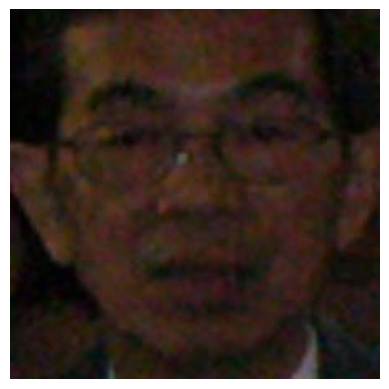

Shape: (224, 224, 3)


In [13]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/train/1.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")

# 2. Loading and preprocessing data UTKface

## Download data

In [14]:
!pip install PyDrive

In [15]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import tarfile

# Authenticate PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared Google Drive folder
folder_id = '1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Loop through the files and download each .tar.gz file
for file in file_list:
    if file['title'].endswith('.tar.gz'):
        print(f'Downloading {file["title"]}')
        file.GetContentFile(file['title'])

        # Extract the .tar.gz file
        tar = tarfile.open(file['title'])
        tar.extractall('/content/extracted')  # Extract all files to /content/extracted directory
        tar.close()

        print(f'Extracted {file["title"]}')

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz


## Data Preprocessing

### Data test

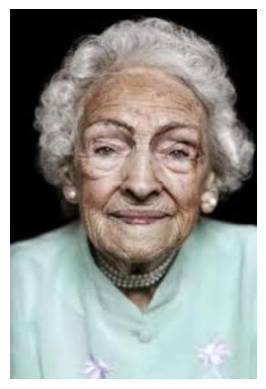

Shape: (551, 368, 3)


In [16]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/part3/100_1_0_20170119212053665.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")


### Delete non-images

In [17]:
import os

def delete_non_image_files(directories, allowed_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
    for directory in directories:
        for filename in os.listdir(directory):
            if not filename.lower().endswith(allowed_extensions):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete non-image files
delete_non_image_files(directories)

Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/.DS_Store


### Delete invalid mesasges

In [18]:
import os
import re

def delete_invalid_images(directories):
    # Regular expression pattern to match the desired format
    pattern = re.compile(r'^\d+_\d+_\d+_\d+\.\w+$')

    for directory in directories:
        for filename in os.listdir(directory):
            # Check if the filename matches the desired pattern
            if not pattern.match(filename):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete invalid images
delete_invalid_images(directories)

Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg


### Creating lists for training

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Initialize lists to store images and labels
images = []
ages_utkface = []
genders_utkface = []
ethnicities_utkface = []
files_utkface = []  # New list to store file paths

# Process each directory
for directory in directories:
    print(f"Processing from: {directory}")
    files = os.listdir(directory)

    for file in files:
        file_path = os.path.join(directory, file)  # Create the full file path

        if image is not None:  # Check if the image was loaded successfully
            # Parse filename to extract labels
            split_var = file.split('_')
            ages_utkface.append(int(split_var[0]))
            genders_utkface.append(int(split_var[1]))
            ethnicities_utkface.append(int(split_var[2]))
            files_utkface.append(file_path)  # Store the file path in the list
        else:
            print(f"Failed to load image: {file_path}")

# Create a dataframe from the lists
df_utkface = pd.DataFrame({
    'age': ages_utkface,
    'gender': genders_utkface,
    'ethnicity': ethnicities_utkface,
    'file': files_utkface  # Add the file paths as a column
})

Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


In [20]:
# Create a DataFrame from the lists
df_utkface_raw = pd.DataFrame({
    'file': files_utkface,
    'age_raw': ages_utkface,
    'gender_code': genders_utkface,
    'race_code': ethnicities_utkface
})

## Mapping

In [21]:
### Mapping age
# Define the age mapping function
def map_age(age):
    if age <= 2:
        return '0-2'
    elif 3 <= age <= 9:
        return '3-9'
    elif 10 <= age <= 19:
        return '10-19'
    elif 20 <= age <= 29:
        return '20-29'
    elif 30 <= age <= 39:
        return '30-39'
    elif 40 <= age <= 49:
        return '40-49'
    elif 50 <= age <= 59:
        return '50-59'
    elif 60 <= age <= 69:
        return '60-69'
    else:
        return '70+'

# Map the 'age_raw' column to the 'age' column
df_utkface_raw['age'] = df_utkface_raw['age_raw'].apply(map_age)

# Setting the desired order for 'age'
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_utkface_raw['age'] = df_utkface_raw['age'].astype('category')
df_utkface_raw['age'] = df_utkface_raw['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
df_utkface_raw['age_code'] = df_utkface_raw['age'].cat.codes

In [22]:
# Mapping gender
# Define gender mapping
gender_map = {0: 'Male', 1: 'Female'}

# Map 'gender_code' to the 'gender' column
df_utkface_raw['gender'] = df_utkface_raw['gender_code'].map(gender_map)

# Mapping race
# Define race mapping based on the specified order
race_map_utk = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Map 'race_code' to the 'race' column
df_utkface_raw['race'] = df_utkface_raw['race_code'].map(race_map_utk)

In [23]:
df_utkface_code = df_utkface_raw[['file','age_code','gender_code','race_code']]
df_utkface_eda = df_utkface_raw[['age','gender','race']]

# 3. EDA

## EDA Fairface

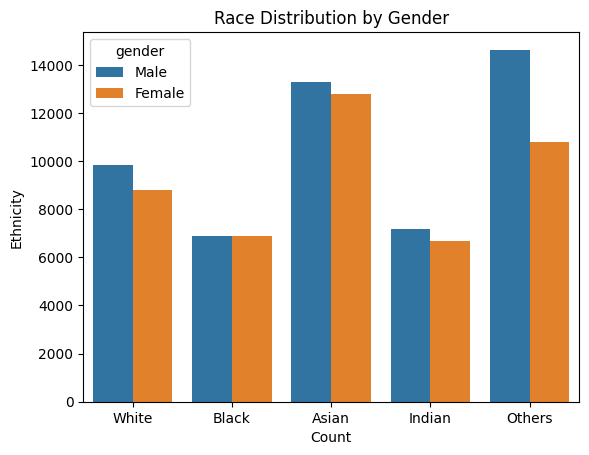

In [24]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=df_fairface_eda, x='race', hue='gender')

# Adding plot labels
plt.title('Race Distribution by Gender')
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

<Axes: xlabel='gender', ylabel='count'>

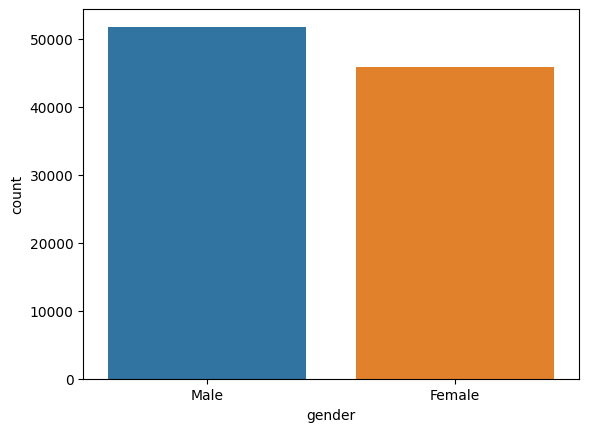

In [25]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df_fairface_eda, x ='gender', hue ='gender')

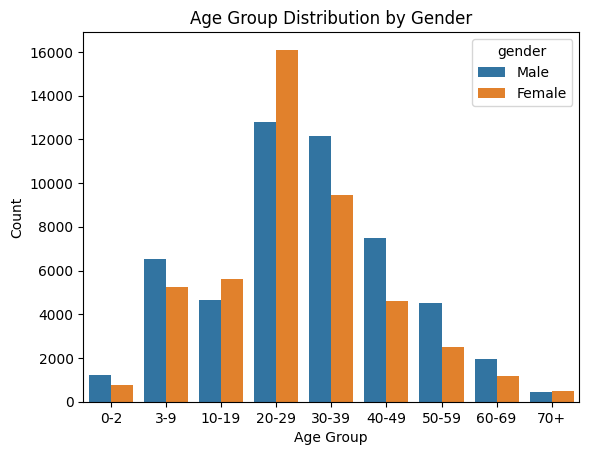

In [26]:
# Ensure the age column in df_fairface_eda has the correct category order using .loc to avoid the warning
df_fairface_eda.loc[:, 'age'] = pd.Categorical(df_fairface_eda['age'], categories=age_order, ordered=True)

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=df_fairface_eda, x='age', hue='gender', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

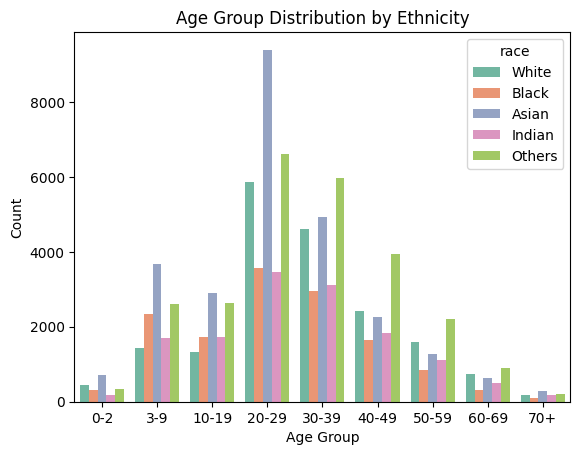

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=df_fairface_eda, x='age', hue='race', palette='Set2', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## EDA UTKface

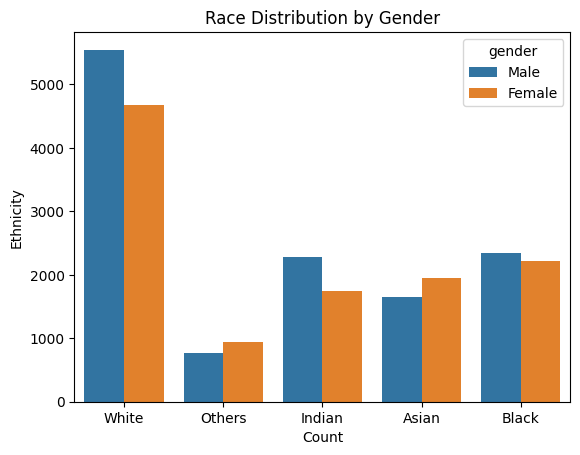

In [28]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=df_utkface_eda, x='race', hue='gender')

# Adding plot labels
plt.title('Race Distribution by Gender')
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

<Axes: xlabel='gender', ylabel='count'>

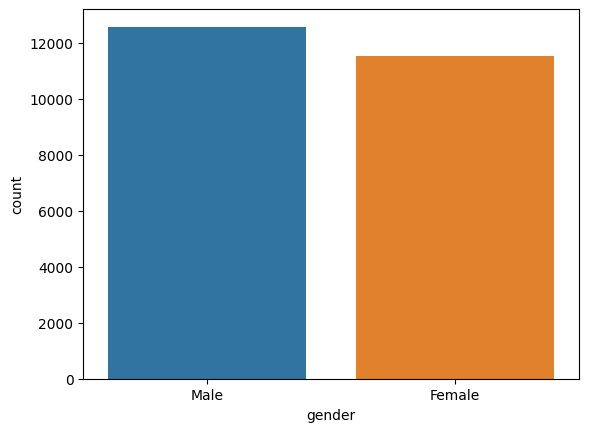

In [29]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df_utkface_eda, x ='gender', hue ='gender')

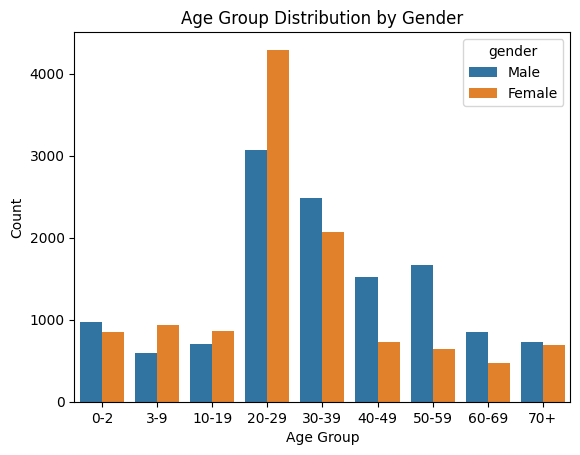

In [30]:
# Ensure the age column in df_utkface_eda has the correct category order using .loc to avoid the warning
df_utkface_eda.loc[:, 'age'] = pd.Categorical(df_utkface_eda['age'], categories=age_order, ordered=True)

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=df_utkface_eda, x='age', hue='gender', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

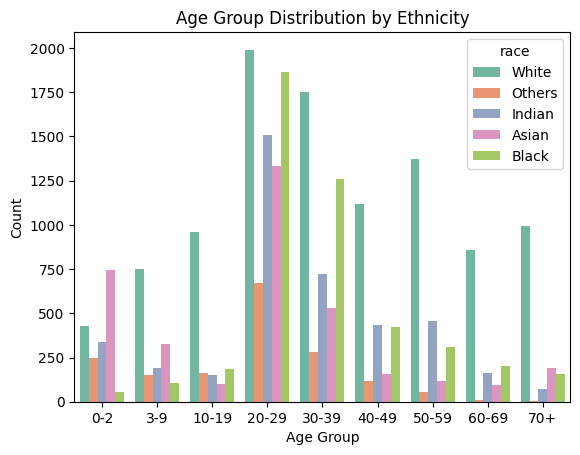

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=df_utkface_eda, x='age', hue='race', palette='Set2')

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 4. Normalizing age group distribution
Methods
1. Age groups 0-2 and 3-9 are combined into 0-9
3. Add data from UTKface to: 0-9, 10-19, 40-49, 50-59, 60-69, and 70+

## Current distributions

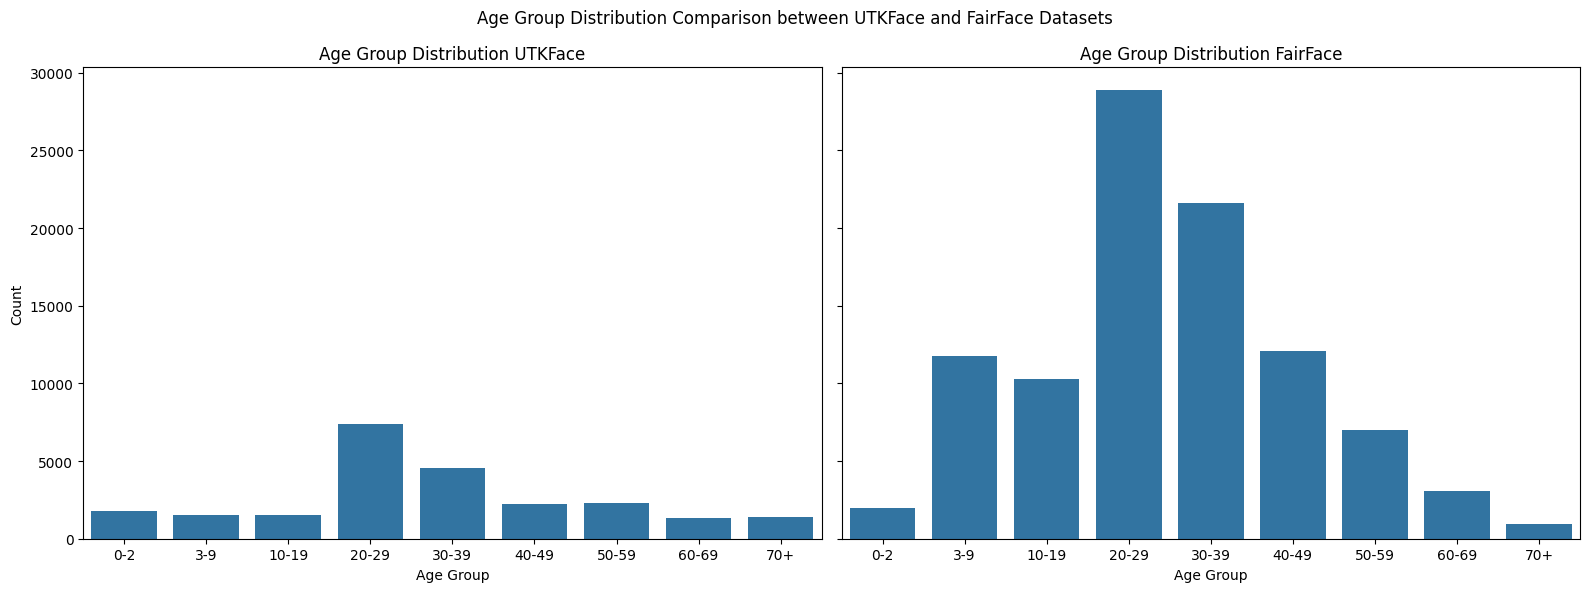

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first distribution for the UTKFace dataset
sns.countplot(data=df_utkface_code, x='age_code', ax=axes[0])
axes[0].set_title('Age Group Distribution UTKFace')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(age_map)))
axes[0].set_xticklabels(age_map.keys())

# Plot the second distribution for the FairFace dataset
sns.countplot(data=df_fairface_code, x='age_code', ax=axes[1])
axes[1].set_title('Age Group Distribution FairFace')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(age_map)))
axes[1].set_xticklabels(age_map.keys())

# Adjust the layout and show the plots
plt.suptitle('Age Group Distribution Comparison between UTKFace and FairFace Datasets')
plt.tight_layout()
plt.show()

## Fairface

In [33]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 (0-2) and 1 (3-9)
    #elif age_code in [6, 7, 8]:
        #return 7  # Merge age groups 7(60-69), and 8(70+) into group 7(60-69)
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_fairface = df_fairface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5,  # 50-59
    7: 6,  # 60-69
    8: 7,  # 70+
}

# Apply the sequential mapping using .loc
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50-59',   # Group 5 (previously group 6)
    6: '60-69',   # Group 6 (previously group 7)
    7: '70+',   # Group 7 (previously group 8)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_fairface.loc[:, 'age'] = df_fairface['age_code'].map(age_group_mapping)


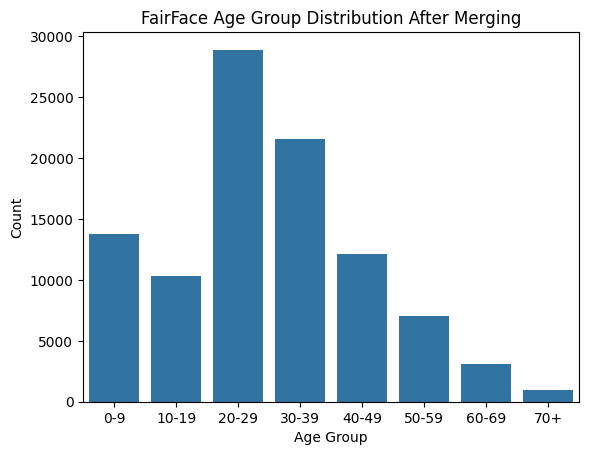

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_fairface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_fairface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('FairFace Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## UTKFace

In [35]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 (0-2) and 1 (3-9)
    #elif age_code in [7, 8]:
        #return 7  # Merge age groups 7(60-69), and 8(70+) into group 7(60-69)
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_utkface = df_utkface_code.copy()

# Explicitly cast the 'age_code' column to a larger integer type to avoid dtype issues
df_utkface['age_code'] = df_utkface['age_code'].astype('int64')

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5,  # 50-59
    7: 6,  # 60-69
    8: 7,  # 70+
}

# Apply the sequential mapping using .loc
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50-59',   # Group 5 (previously group 6)
    6: '60-69',   # Group 6 (previously group 7)
    7: '70+',   # Group 7 (previously group 8)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_utkface.loc[:, 'age'] = df_utkface['age_code'].map(age_group_mapping)

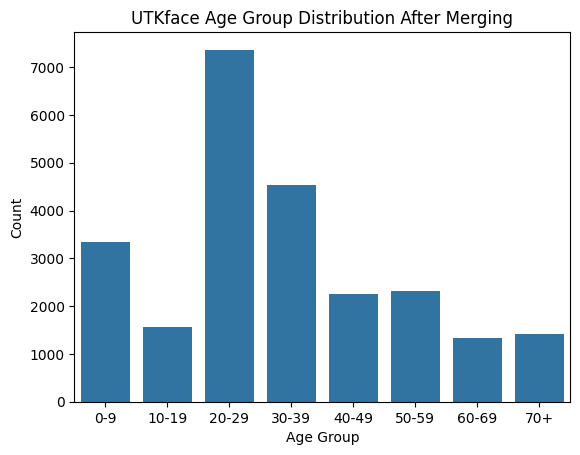

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_utkface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_utkface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('UTKface Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## Concatenating age groups 0, 1, 4, 5, and 6
- Age groups: 0-9, 10-19, 40-49, 50-59, and 60+

<ipython-input-37-aa1b0141c384>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_utkface['dataset'] = 'UTK'


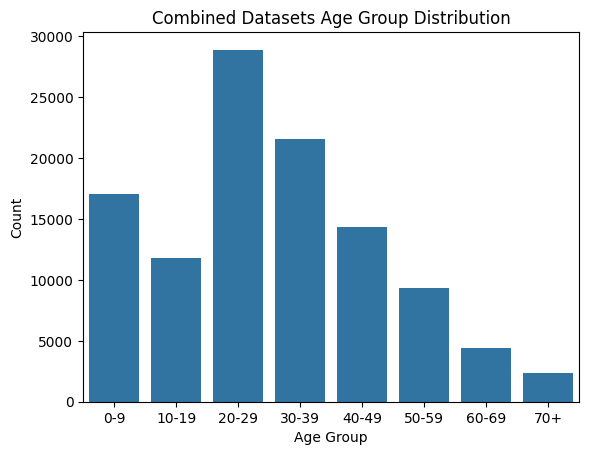

In [37]:
import pandas as pd

# Step 1: Filter `df_utkface` to include only the specified age groups
filtered_utkface = df_utkface[df_utkface['age_code'].isin([0, 1, 4, 5, 6, 7])]

# Add columns indicating if the image is from UTK or FairFace
filtered_utkface['dataset'] = 'UTK'
df_fairface['dataset'] = 'FairFace'

# Step 2: Concatenate the filtered `df_utkface` with `df_fairface`
df = pd.concat([df_fairface, filtered_utkface], ignore_index=True)

# Define the correct order of the age groups based on the mapping
age_order = sorted(df['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('Combined Datasets Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 5. Downsample, split data into (train, val, test) and free up memory

### Race Codes

UTKFace:

0: 'White'

1: 'Black'

2: 'Asian'

3: 'Indian'

4: 'Others'


FairFace:

0: 'White'

1: 'Black'

2: 'Asian'

3: 'Indian'

4: 'Others'

### Downsampling

In [ ]:
# Find age group with lowest n
lowest_n = df['age'].value_counts().sort_values(ascending=True).iloc[0]

# Downsample
df_down = df.groupby('age').apply(lambda x: x.sample(lowest_n)).reset_index(drop=True)

# Display
df_down.head()

<ipython-input-33-11961f80dd77>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_down = df.groupby('age').apply(lambda x: x.sample(lowest_n)).reset_index(drop=True)


,file,age_code,gender_code,race_code,age,dataset
0,/content/extracted/val/8023.jpg,0,1,2,0-9,FairFace
1,/content/extracted/train/24260.jpg,0,0,0,0-9,FairFace
2,/content/extracted/part1/7_0_0_201701102252320...,0,0,0,0-9,UTK
3,/content/extracted/train/16153.jpg,0,0,0,0-9,FairFace
4,/content/extracted/val/10337.jpg,0,0,2,0-9,FairFace


### Data split

In [ ]:
# sample_df = df.sample(n=100000, random_state=42)  # For testing

# Create lists
images, ages, races, genders = create_lists(df_down)
print(f"Loaded {len(images)} images.")

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

# Split data
X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender = split_data(images, ages, races, genders)

Loaded 18992 images.
Number of age classes: 8
Number of gender classes: 2
Number of ethnicity classes: 5
Training set: (7122, 224, 224, 3), Training labels: (7122,)
Age validation set: (1899, 224, 224, 3), Age validation labels: (1899,)
Age test set: (475, 224, 224, 3), Age test labels: (475,)
Race validation labels: (1899,)
Race test labels: (475,)
Gender validation labels: (1899,)
Gender test labels: (475,)


### Free up memory

In [ ]:
# Free up memory
keep_vars = []
keep_vars.extend(['df_down', 'df']) # Dataframes
keep_vars.extend(['evaluate_and_plot', 'create_lists']) # Functions
keep_vars.extend(['images', 'ages', 'races', 'genders', 'images_preprocessed']) # Data lists
keep_vars.extend(['X_train', 'X_val', 'X_test', 'y_train_age', 'y_val_age', 'y_test_age', 'y_train_races', 'y_val_races', 'y_test_races', 'y_train_gender', 'y_val_gender', 'y_test_gender']) # Data splits
keep_vars.extend(['num_classes_age', 'num_classes_gender', 'num_classes_ethnicity']) # Number of labels per variable

# Get all global variables excluding special variables
all_vars = [var for var in globals() if not var.startswith('_')]

# Variables to delete
vars_to_delete = [var for var in all_vars if var not in keep_vars]

# Delete unwanted variables
for var in vars_to_delete:
    del globals()[var]


# 6. Finding a Base

## Resnet

In [39]:
images, ages, races, genders = create_lists(df)
print(f"Loaded {len(images)} images.")

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

Loaded 109890 images.
Number of age classes: 8
Number of gender classes: 2
Number of ethnicity classes: 5


In [ ]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the ResNet50V2 preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size (this part stays the same)
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project/"
model_name = 'best_resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

KeyboardInterrupt: 

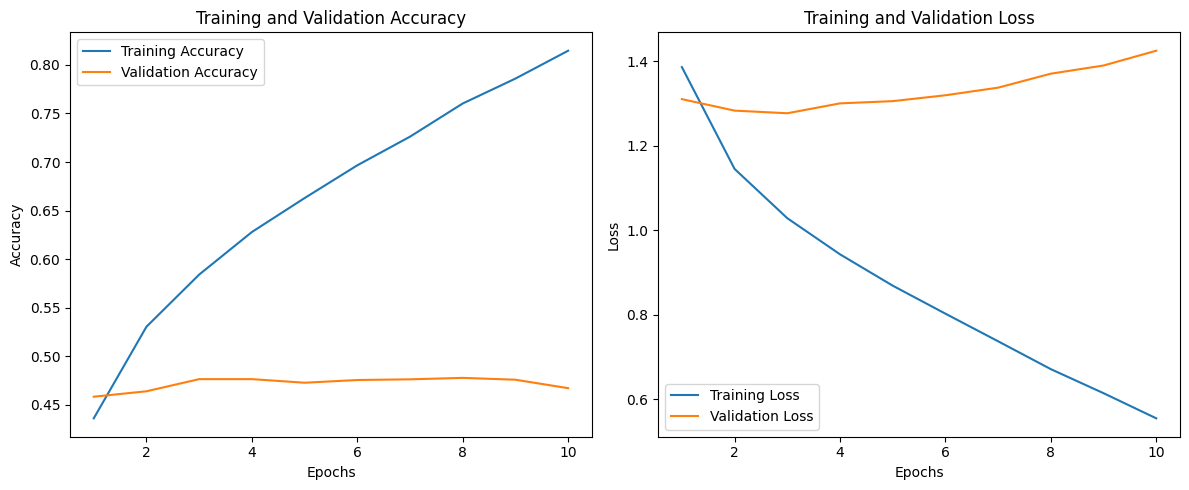

In [ ]:
evaluate_and_plot(resnet_history)

## Xception

In [ ]:
from keras.applications.xception import preprocess_input  # Update the import for Xception
from keras.applications import Xception  # Import the Xception model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the Xception preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size (this part stays the same)
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the Xception model using the preprocessed images
conv_base = Xception(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using Xception as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)
83683744/83683744 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
            

In [ ]:
# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project/"
model_name = 'best_xception_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
xception_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

evaluate_and_plot(xception_history)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 1.4461 - accuracy: 0.4200
Epoch 1: val_accuracy improved from -inf to 0.44210, saving model to /content/drive/MyDrive/Visual reg/Project/best_xception_model_baseline.keras
1172/1172 [==============================] - 701s 595ms/step - loss: 1.4461 - accuracy: 0.4200 - val_loss: 1.3590 - val_accuracy: 0.4421
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 1.2221 - accuracy: 0.4984
Epoch 2: val_accuracy improved from 0.44210 to 0.46070, saving model to /content/drive/MyDrive/Visual reg/Project/best_xception_model_baseline.keras
1172/1172 [==============================] - 684s 584ms/step - loss: 1.2221 - accuracy: 0.4984 - val_loss: 1.3349 - val_accuracy: 0.4607
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.5477
Epoch 3: val_accuracy did not improve from 0.46070
1172/1172 [==============================] - 681s 582ms/step - loss: 1.1191 - accuracy

NameError: name 'evaluate_and_plot' is not defined

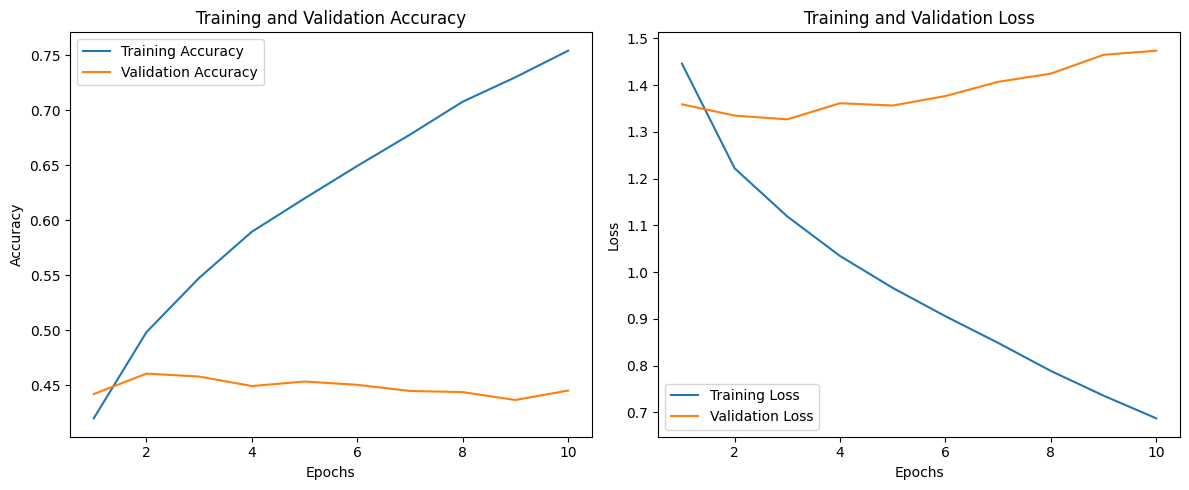

In [ ]:
evaluate_and_plot(xception_history)

## MobileNet

In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Data split
X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender = data_split(images_preprocessed, ages, races, genders)

Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)


In [ ]:
# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")


inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)

outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 960)               3840      
 Normalization)                                                  
                                                                 


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/"
model_name = 'best_mobilenet_model_baseline_.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 1.4393 - accuracy: 0.4148
Epoch 1: val_accuracy improved from -inf to 0.44600, saving model to /content/best_mobilenet_model_baseline_.keras
1172/1172 [==============================] - 208s 174ms/step - loss: 1.4393 - accuracy: 0.4148 - val_loss: 1.3416 - val_accuracy: 0.4460
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 1.2277 - accuracy: 0.4942
Epoch 2: val_accuracy improved from 0.44600 to 0.45930, saving model to /content/best_mobilenet_model_baseline_.keras
1172/1172 [==============================] - 202s 172ms/step - loss: 1.2277 - accuracy: 0.4942 - val_loss: 1.3112 - val_accuracy: 0.4593
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.5342
Epoch 3: val_accuracy improved from 0.45930 to 0.46400, saving model to /content/best_mobilenet_model_baseline_.keras
1172/1172 [==============================] - 200s 171ms/step - loss: 1.1441 - acc

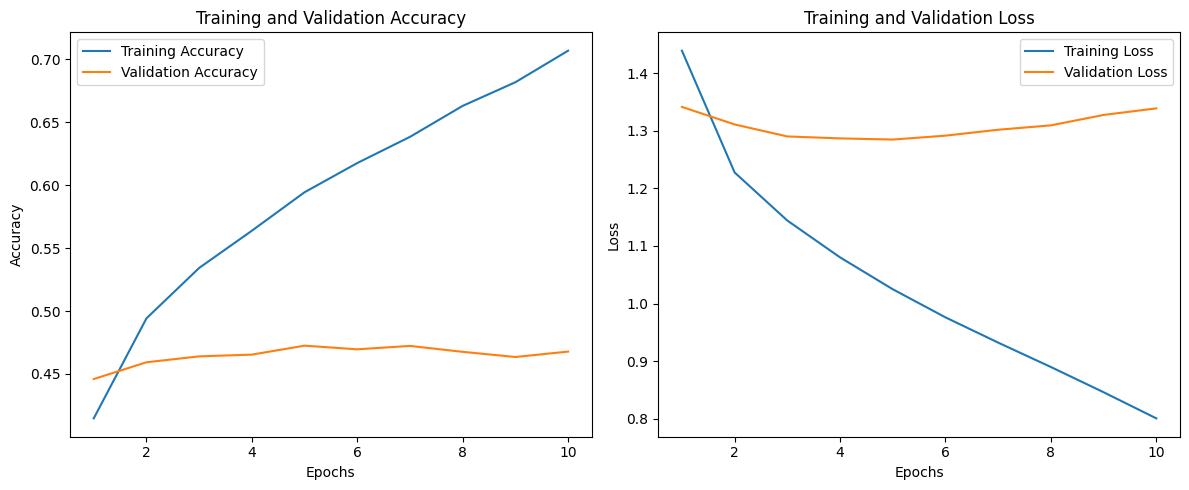

In [ ]:
evaluate_and_plot(mobilenet_history)

# Learning Rate Finder range for ResNet50V2

In [ ]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the ResNet50V2 preprocessing
images_preprocessed = preprocess_input(images)

# Data split
X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender = split_data(images_preprocessed, ages, races, genders)

TypeError: unsupported operand type(s) for /=: 'list' and 'float'

lr post: 1.8063139931740613e-06
586/586 [==============================] - 528s 893ms/step - loss: 1.6548 - accuracy: 0.3597


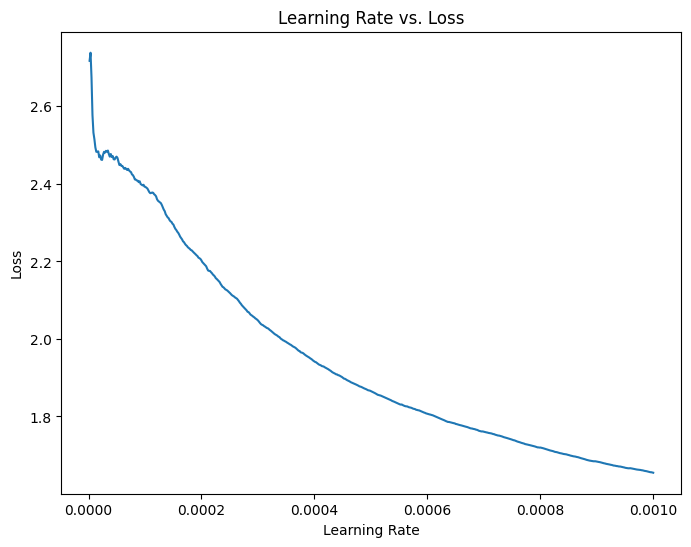

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
initial_learning_rate=1e-7
max_learning_rate=1e-3

### Learning rate finder
lr_finder = LearningRateFinder(min_lr=initial_learning_rate, max_lr=max_learning_rate, steps_per_epoch=steps_per_epoch, epochs=1)

### Checkpoint
model_name = 'lr_range_resnet50v2_model_baseline.keras'
# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

### Compile
# Compile the model again with the initial learning rate
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Train the model using the Learning Rate Finder
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=1,  # For learning rate finder, use only one epoch
    batch_size=batch_size,
    callbacks=[lr_finder],
    verbose=1
)

# Plot the learning rate vs. loss
plt.figure(figsize=(8, 6))
plt.plot(lr_finder.learning_rates, lr_finder.losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Loss')
plt.show()

# 7. Baseline ResNet50V2
- learning rate at 0.00015 (1,5e-4)

In [ ]:
# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   


In [ ]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the ResNet50V2 preprocessing
images_preprocessed = preprocess_input(images)

# Data split
X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender = split_data(images_preprocessed, ages, races, genders)

Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
initial_learning_rate=1e-6
max_learning_rate=1e-4

### Learning rate finder
lr_finder = LearningRateFinder(min_lr=initial_learning_rate, max_lr=max_learning_rate, steps_per_epoch=steps_per_epoch, epochs=1)

### Checkpoint
model_name = 'lr_range_resnet50v2_model_finetune_blocks_5.keras'
# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

### Compile
# Compile the model again with the initial learning rate
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Train the model using the Learning Rate Finder
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=1,  # For learning rate finder, use only one epoch
    batch_size=batch_size,
    callbacks=[lr_finder],
    verbose=1
)

lr post: 2.704778156996587e-06
586/586 [==============================] - 537s 909ms/step - loss: 1.4563 - accuracy: 0.4154


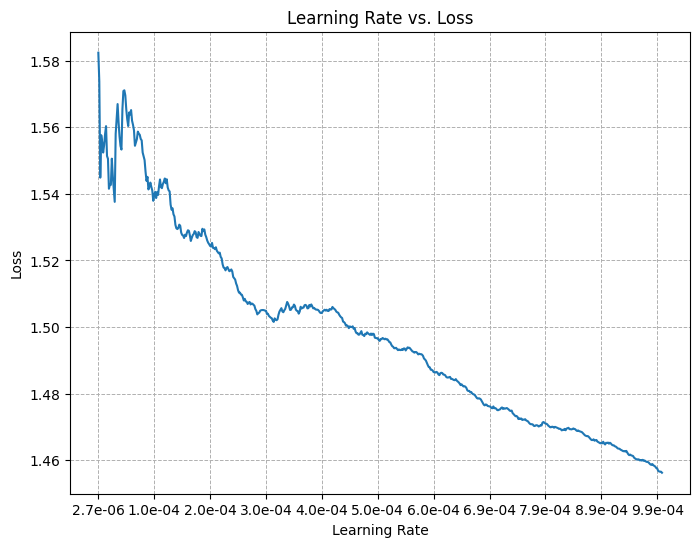

In [ ]:
import matplotlib.pyplot as plt

# Sample plot using the existing data
plt.figure(figsize=(8, 6))
plt.plot(lr_finder.learning_rates, lr_finder.losses)

# Limit the number of x-axis ticks by taking every nth value (e.g., every 5th value)
step = len(lr_finder.learning_rates) // 10  # Choose every 10th tick for display or adjust `step` as needed
selected_ticks = lr_finder.learning_rates[::step]  # Select every nth value from the learning rates
selected_labels = [f'{lr:.1e}' for lr in selected_ticks]  # Format the selected labels

# Customize x-axis ticks to show reduced number
plt.xticks(ticks=selected_ticks, labels=selected_labels)

# Customize y-axis tick precision (if necessary)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

# Add gridlines for better visualization
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Set axis labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Loss')

# Show the plot
plt.show()


In [40]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the ResNet50V2 preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size (this part stays the same)
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.65, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

Training set: (28845, 224, 224, 3), Training labels: (28845,)
Age validation set: (7692, 224, 224, 3), Age validation labels: (7692,)
Age test set: (1924, 224, 224, 3), Age test labels: (1924,)
Race validation labels: (7692,)
Race test labels: (1924,)
Gender validation labels: (7692,)
Gender test labels: (1924,)


In [41]:
# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 30% rate

x = layers.Dense(64, activation='relu')(x)


# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   


In [42]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)


Epoch 1/20
902/902 [==============================] - ETA: 0s - loss: 1.9143 - accuracy: 0.2884
Epoch 1: val_accuracy improved from -inf to 0.39444, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
902/902 [==============================] - 453s 497ms/step - loss: 1.9143 - accuracy: 0.2884 - val_loss: 1.4964 - val_accuracy: 0.3944
Epoch 2/20
902/902 [==============================] - ETA: 0s - loss: 1.5886 - accuracy: 0.3700
Epoch 2: val_accuracy improved from 0.39444 to 0.42148, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
902/902 [==============================] - 438s 486ms/step - loss: 1.5886 - accuracy: 0.3700 - val_loss: 1.4107 - val_accuracy: 0.4215
Epoch 3/20
902/902 [==============================] - ETA: 0s - loss: 1.4915 - accuracy: 0.3912
Epoch 3: val_accuracy improved from 0.42148 to 0.44202, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
902/902 [======================

Best Training Accuracy: 0.5345
Best Validation Accuracy: 0.4801
Best Training Loss: 1.1100
Best Validation Loss: 1.2797


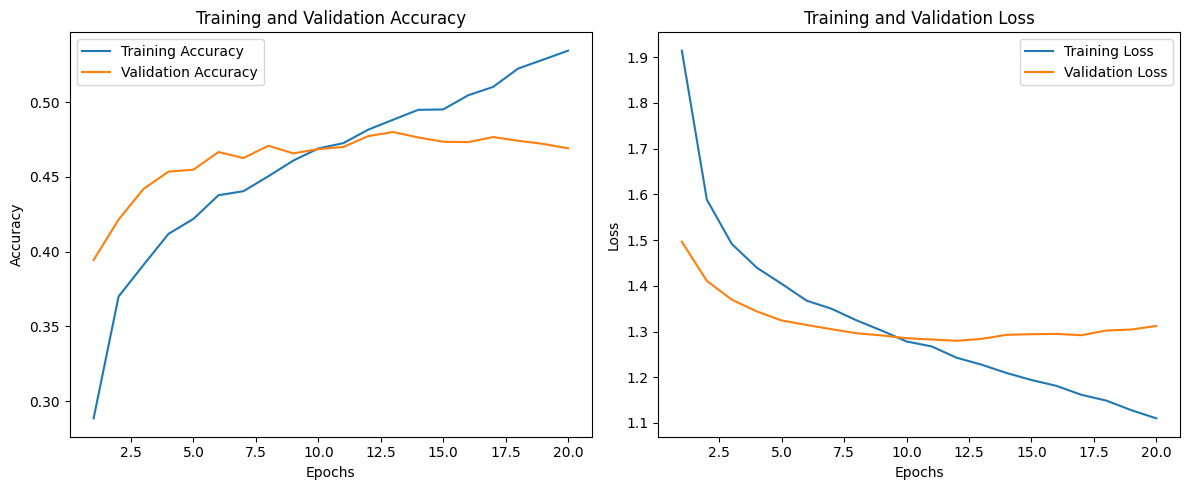

In [43]:
evaluate_and_plot(resnet_history)

# 8. Fine-tuning ResNet50V2
The ResNet50V2 architecture consists of 5 "blocks" of CNN layers. We will unfreeze these blocks for fine-tuning starting by the last block.
- Unfreeze all layers
- Unfreeze 1-5 blocks

## Block 5

### Prepare model

In [ ]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images_preprocessed[0].shape[0],
    images_preprocessed[0].shape[1],
    images_preprocessed[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
conv_base.trainable = True

conv_base.summary()

# Find the index of 'conv4_block6_out'
layer_name = 'conv4_block6_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv4_block6_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv4_block6_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")


94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [ ]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048  

### Train model
- Learning Rate finder is not used

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_finetune_blocks_5.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/5
1172/1172 [==============================] - ETA: 0s - loss: 1.9678 - accuracy: 0.2766
Epoch 1: val_accuracy improved from -inf to 0.38020, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5.keras
1172/1172 [==============================] - 911s 773ms/step - loss: 1.9678 - accuracy: 0.2766 - val_loss: 1.6760 - val_accuracy: 0.3802
Epoch 2/5
1172/1172 [==============================] - ETA: 0s - loss: 1.4612 - accuracy: 0.4345
Epoch 2: val_accuracy improved from 0.38020 to 0.42440, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5.keras
1172/1172 [==============================] - 883s 754ms/step - loss: 1.4612 - accuracy: 0.4345 - val_loss: 1.4680 - val_accuracy: 0.4244
Epoch 3/5
1172/1172 [==============================] - ETA: 0s - loss: 1.2812 - accuracy: 0.4964
Epoch 3: val_accuracy improved from 0.42440 to 0.45330, saving model to /content/drive/MyDrive/DL for VR/Project/Mod

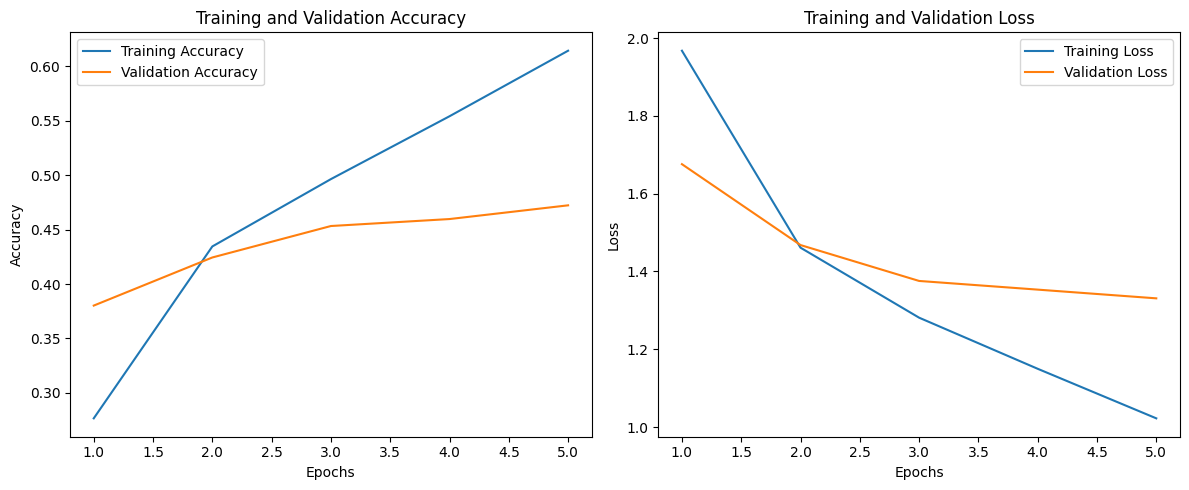

In [ ]:
evaluate_and_plot(resnet_history)

## Block 5 + 4

In [ ]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images_preprocessed[0].shape[0],
    images_preprocessed[0].shape[1],
    images_preprocessed[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
conv_base.trainable = True

# Reset all layers to non-trainable
for layer in conv_base.layers:
    layer.trainable = False

# Find the index of 'conv3_block4_out'
layer_name = 'conv3_block4_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv3_block4_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv3_block4_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
print("\nTrainable status after processing 'conv3_block4_out':")
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")

Found layer 'conv3_block4_out' at index 85

Trainable status after processing 'conv3_block4_out':
Layer 0: input_15, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_pad, Trainable: False
Layer 11: conv2_block1_2_conv, Trainable: False
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: False
Layer 14: conv2_block1_0_conv, Trainable: False
Layer 15: conv2_block1_3_conv, Trainable: False
Layer 16: conv2_block1_out, Trainable: False
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_relu, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable:

In [ ]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_28 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_35 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_29 (Ba  (None, 512)               2048

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_finetune_blocks_5_4.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/5
1172/1172 [==============================] - ETA: 0s - loss: 1.9854 - accuracy: 0.2692
Epoch 1: val_accuracy improved from -inf to 0.39920, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5_4.keras
1172/1172 [==============================] - 1186s 1s/step - loss: 1.9854 - accuracy: 0.2692 - val_loss: 1.5628 - val_accuracy: 0.3992
Epoch 2/5
1172/1172 [==============================] - ETA: 0s - loss: 1.4102 - accuracy: 0.4426
Epoch 2: val_accuracy improved from 0.39920 to 0.45550, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5_4.keras
1172/1172 [==============================] - 1171s 999ms/step - loss: 1.4102 - accuracy: 0.4426 - val_loss: 1.3451 - val_accuracy: 0.4555
Epoch 3/5
1172/1172 [==============================] - ETA: 0s - loss: 1.2291 - accuracy: 0.5027
Epoch 3: val_accuracy improved from 0.45550 to 0.47560, saving model to /content/drive/MyDrive/DL for VR/Project/

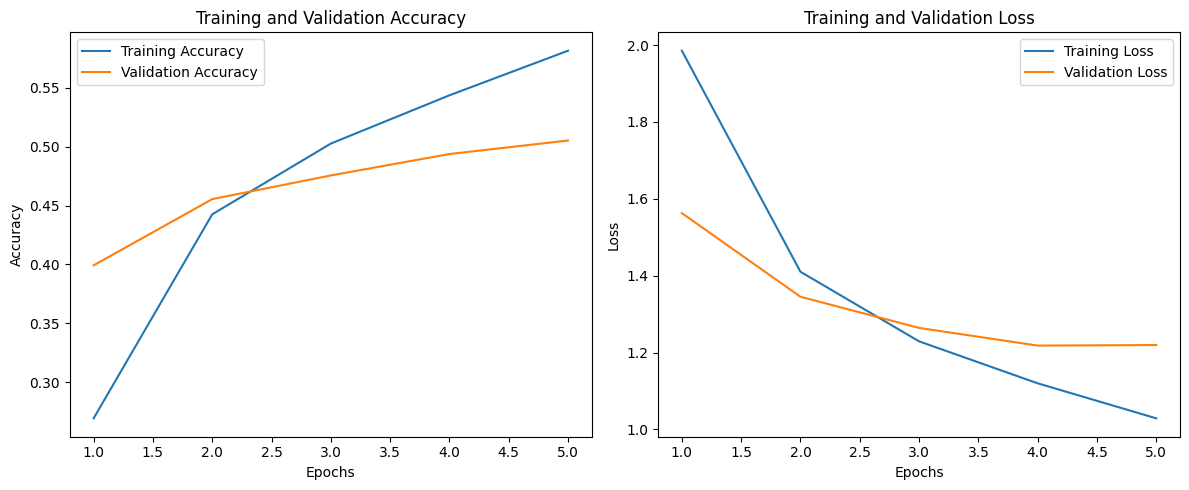

In [ ]:
evaluate_and_plot(resnet_history)

## Block 5 + 4 + 3

In [ ]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images_preprocessed[0].shape[0],
    images_preprocessed[0].shape[1],
    images_preprocessed[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
conv_base.trainable = True

# Reset all layers to non-trainable
for layer in conv_base.layers:
    layer.trainable = False

# Find the index of 'conv2_block3_out'
layer_name = 'conv2_block3_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv2_block3_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv2_block3_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
print("\nTrainable status after processing 'conv2_block3_out':")
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")

Found layer 'conv2_block3_out' at index 39

Trainable status after processing 'conv2_block3_out':
Layer 0: input_17, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_pad, Trainable: False
Layer 11: conv2_block1_2_conv, Trainable: False
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: False
Layer 14: conv2_block1_0_conv, Trainable: False
Layer 15: conv2_block1_3_conv, Trainable: False
Layer 16: conv2_block1_out, Trainable: False
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_relu, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable:

In [ ]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_32 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_40 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_33 (Ba  (None, 512)               2048

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_finetune_blocks_5_4_3.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/5
1172/1172 [==============================] - ETA: 0s - loss: 1.8976 - accuracy: 0.2953
Epoch 1: val_accuracy improved from -inf to 0.39910, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5_4_3.keras
1172/1172 [==============================] - 1497s 1s/step - loss: 1.8976 - accuracy: 0.2953 - val_loss: 1.6082 - val_accuracy: 0.3991
Epoch 2/5
1172/1172 [==============================] - ETA: 0s - loss: 1.4334 - accuracy: 0.4359
Epoch 2: val_accuracy improved from 0.39910 to 0.44370, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5_4_3.keras
1172/1172 [==============================] - 1481s 1s/step - loss: 1.4334 - accuracy: 0.4359 - val_loss: 1.3787 - val_accuracy: 0.4437
Epoch 3/5
1172/1172 [==============================] - ETA: 0s - loss: 1.2680 - accuracy: 0.4878
Epoch 3: val_accuracy improved from 0.44370 to 0.47240, saving model to /content/drive/MyDrive/DL for VR/Project

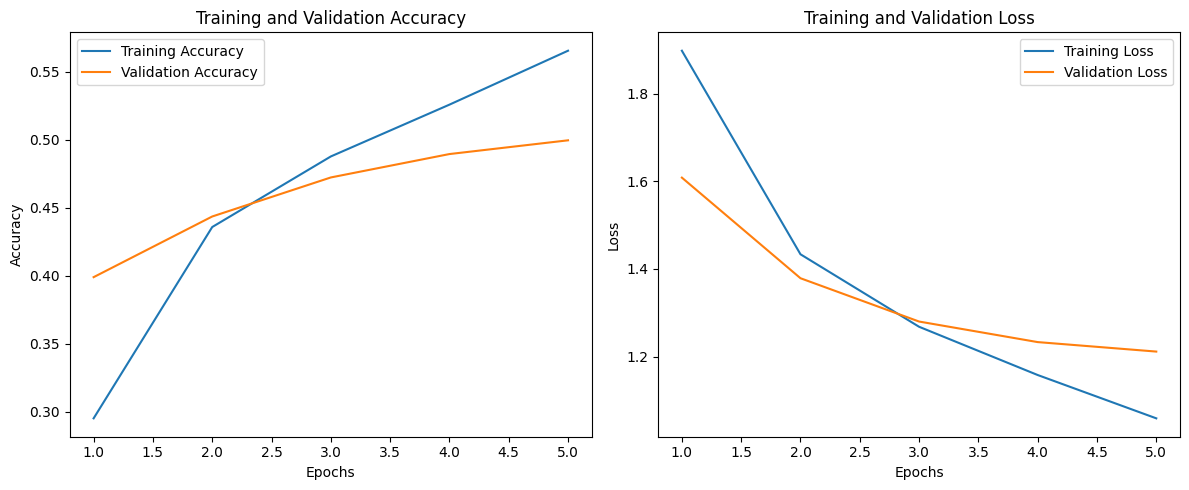

In [ ]:
evaluate_and_plot(resnet_history)

## Block 5 + 4 + 3 + 2

In [ ]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images_preprocessed[0].shape[0],
    images_preprocessed[0].shape[1],
    images_preprocessed[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
conv_base.trainable = True

# Reset all layers to non-trainable
for layer in conv_base.layers:
    layer.trainable = False

# Find the index of 'pool1_pool'
layer_name = 'pool1_pool'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'pool1_pool'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'pool1_pool'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
print("\nTrainable status after processing 'pool1_pool':")
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")


Found layer 'pool1_pool' at index 4

Trainable status after processing 'pool1_pool':
Layer 0: input_19, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: True
Layer 7: conv2_block1_1_conv, Trainable: True
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: True
Layer 10: conv2_block1_2_pad, Trainable: True
Layer 11: conv2_block1_2_conv, Trainable: True
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: True
Layer 14: conv2_block1_0_conv, Trainable: True
Layer 15: conv2_block1_3_conv, Trainable: True
Layer 16: conv2_block1_out, Trainable: True
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_relu, Trainable: True
Layer 19: conv2_block2_1_conv, Trainable: True
Layer 20: conv2_b

In [ ]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_36 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_45 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_37 (Ba  (None, 512)               2048

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_finetune_blocks_5_4_3_2.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 1.8679 - accuracy: 0.2990
Epoch 1: val_accuracy improved from -inf to 0.39250, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5_4_3_2.keras
1172/1172 [==============================] - 1845s 2s/step - loss: 1.8679 - accuracy: 0.2990 - val_loss: 1.5722 - val_accuracy: 0.3925
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 1.4118 - accuracy: 0.4373
Epoch 2: val_accuracy improved from 0.39250 to 0.44980, saving model to /content/drive/MyDrive/DL for VR/Project/Models/resnet50v2_model_finetune_blocks_5_4_3_2.keras
1172/1172 [==============================] - 1841s 2s/step - loss: 1.4118 - accuracy: 0.4373 - val_loss: 1.3641 - val_accuracy: 0.4498
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 1.2437 - accuracy: 0.4946
Epoch 3: val_accuracy improved from 0.44980 to 0.47040, saving model to /content/drive/MyDrive/DL for VR/

KeyboardInterrupt: 

In [ ]:
evaluate_and_plot(resnet_history)

## Block 5 + 4 + 3 + 2 + 1

In [ ]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images[0].shape[0],
    images[0].shape[1],
    images[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
conv_base.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_finetune_blocks_5_4_3_2_1.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/30
223/223 [==============================] - ETA: 0s - loss: 2.5910 - accuracy: 0.1529
Epoch 1: val_accuracy improved from -inf to 0.15534, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/resnet50v2_model_finetune_blocks_5_4_3_2_1.keras
223/223 [==============================] - 353s 2s/step - loss: 2.5910 - accuracy: 0.1529 - val_loss: 2.2229 - val_accuracy: 0.1553
Epoch 2/30
223/223 [==============================] - ETA: 0s - loss: 2.1805 - accuracy: 0.2211
Epoch 2: val_accuracy improved from 0.15534 to 0.25698, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/resnet50v2_model_finetune_blocks_5_4_3_2_1.keras
223/223 [==============================] - 340s 2s/step - loss: 2.1805 - accuracy: 0.2211 - val_loss: 2.1144 - val_accuracy: 0.2570
Epoch 3/30
223/223 [==============================] - ETA: 0s - loss: 1.8703 - accuracy: 0.3110
Epoch 3: val_accuracy improved from 0.25698 to 0.30279, saving model to /content/

Best Training Accuracy: 0.9997
Best Validation Accuracy: 0.4218
Best Training Loss: 0.0311
Best Validation Loss: 1.6344


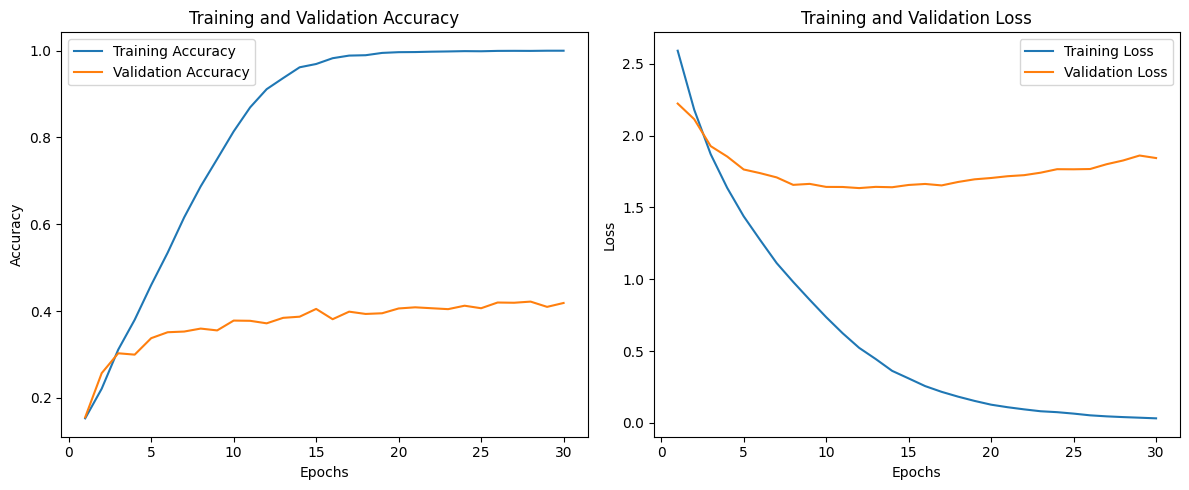

In [ ]:
evaluate_and_plot(resnet_history)

# 9. Multitask Learning

## Model setup

1: Import convolutional base

2: Unfreeze all layers except BatchNormalization layers

3: Build model architecture

4: Compile, checkpoints, train

In [ ]:
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np
input_shape = images[0].shape

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
conv_base.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
age = layers.Dense(512, activation='relu')(x)
age = layers.BatchNormalization()(age)
age = layers.Dense(256, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dense(128, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dense(64, activation='relu')(age)
age = layers.Dense(num_classes_age, activation="softmax", name='age_output')(age)
gender = layers.Dense(512, activation='relu')(x)
gender = layers.BatchNormalization()(gender)
gender = layers.Dense(256, activation='relu')(gender)
gender = layers.BatchNormalization()(gender)
gender = layers.Dense(128, activation='relu')(gender)
gender = layers.BatchNormalization()(gender)
gender = layers.Dense(64, activation='relu')(gender)
gender = layers.Dense(num_classes_gender, activation="softmax", name='gender_output')(gender)
race = layers.Dense(512, activation='relu')(x)
race = layers.BatchNormalization()(race)
race = layers.Dense(256, activation='relu')(race)
race = layers.BatchNormalization()(race)
race = layers.Dense(128, activation='relu')(race)
race = layers.BatchNormalization()(race)
race = layers.Dense(64, activation='relu')(race)
race = layers.Dense(num_classes_ethnicity, activation="softmax", name='race_output')(race)
multitask_model = keras.Model(inputs=inputs, outputs=[age, gender, race])
multitask_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50v2 (Functional)     (None, 7, 7, 2048)           2356480   ['input_22[0][0]']            
                                                          0                                       
                                                                                                  
 global_average_pooling2d_1  (None, 2048)                 0         ['resnet50v2[0][0]']          
 0 (GlobalAveragePooling2D)                                                                       
                                                                                            

In [ ]:
# Compile model
optimizer = keras.optimizers.Adam(learning_rate = 1e-5)
multitask_model.compile(
    optimizer=optimizer,
    loss=["sparse_categorical_crossentropy", "sparse_categorical_crossentropy", "sparse_categorical_crossentropy"],
    metrics=["accuracy"]
)

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_multitask.keras'

# Save the model in the new Keras format with the best validation accuracy
multitask_checkpoint = ModelCheckpoint(file_path + model_name,
                                       monitor='val_accuracy',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='max')


In [ ]:
# Free up memory
keep_vars = ['multitask_model', 'multitask_checkpoint', 'X_train', 'X_val', 'X_test', 'y_train_age', 'y_val_age', 'y_test_age', 'y_train_races', 'y_val_races', 'y_test_races', 'y_train_gender', 'y_val_gender', 'y_test_gender', 'evaluate_and_plot', 'create_lists', 'df_down', 'df', 'images_preprocessed']

# Get all global variables excluding special variables
all_vars = [var for var in globals() if not var.startswith('_')]

# Variables to delete
vars_to_delete = [var for var in all_vars if var not in keep_vars]

# Delete unwanted variables
for var in vars_to_delete:
    del globals()[var]


In [ ]:
# Train the model
multitask_history = multitask_model.fit(
    X_train,
    [y_train_age, y_train_gender, y_train_races],
    epochs=20,
    batch_size=32,
    validation_data=(X_val, [y_val_age, y_val_gender, y_val_races]),
    callbacks=[multitask_checkpoint]
)

Epoch 1/20
223/223 [==============================] - ETA: 0s - loss: 5.1180 - age_output_loss: 2.3961 - gender_output_loss: 0.9211 - race_output_loss: 1.8009 - age_output_accuracy: 0.1582 - gender_output_accuracy: 0.5844 - race_output_accuracy: 0.2445

223/223 [==============================] - 356s 2s/step - loss: 5.1180 - age_output_loss: 2.3961 - gender_output_loss: 0.9211 - race_output_loss: 1.8009 - age_output_accuracy: 0.1582 - gender_output_accuracy: 0.5844 - race_output_accuracy: 0.2445 - val_loss: 4.4283 - val_age_output_loss: 2.1382 - val_gender_output_loss: 0.7061 - val_race_output_loss: 1.5840 - val_age_output_accuracy: 0.2133 - val_gender_output_accuracy: 0.6314 - val_race_output_accuracy: 0.3202
Epoch 2/20
223/223 [==============================] - ETA: 0s - loss: 4.1100 - age_output_loss: 1.9571 - gender_output_loss: 0.6369 - race_output_loss: 1.5161 - age_output_accuracy: 0.2526 - gender_output_accuracy: 0.6896 - race_output_accuracy: 0.3704

223/223 [==============================] - 341s 2s/step - loss: 4.1100 - age_output_loss: 1.9571 - gender_output_loss: 0.6369 - race_output_loss: 1.5161 - age_output_accuracy: 0.2526 - gender_output_accuracy: 0.6896 - race_output_accuracy: 0.3704 - val_loss: 3.9897 - val_age_output_loss: 1.8559 - val_gender_output_loss: 0.6343 - val_race_output_loss: 1.4994 - val_age_output_accuracy: 0.2886 - val_gender_output_accuracy: 0.6898 - val_race_output_accuracy: 0.3760
Epoch 3/20
223/223 [==============================] - ETA: 0s - loss: 3.5898 - age_output_loss: 1.7160 - gender_output_loss: 0.5076 - race_output_loss: 1.3662 - age_output_accuracy: 0.3324 - gender_output_accuracy: 0.7613 - race_output_accuracy: 0.4361

223/223 [==============================] - 345s 2s/step - loss: 3.5898 - age_output_loss: 1.7160 - gender_output_loss: 0.5076 - race_output_loss: 1.3662 - age_output_accuracy: 0.3324 - gender_output_accuracy: 0.7613 - race_output_accuracy: 0.4361 - val_loss: 3.7078 - val_age_output_loss: 1.7490 - val_gender_output_loss: 0.5574 - val_race_output_loss: 1.4013 - val_age_output_accuracy: 0.3170 - val_gender_output_accuracy: 0.7383 - val_race_output_accuracy: 0.4318
Epoch 4/20
223/223 [==============================] - ETA: 0s - loss: 3.2104 - age_output_loss: 1.5538 - gender_output_loss: 0.4208 - race_output_loss: 1.2358 - age_output_accuracy: 0.3960 - gender_output_accuracy: 0.8061 - race_output_accuracy: 0.4890

223/223 [==============================] - 381s 2s/step - loss: 3.2104 - age_output_loss: 1.5538 - gender_output_loss: 0.4208 - race_output_loss: 1.2358 - age_output_accuracy: 0.3960 - gender_output_accuracy: 0.8061 - race_output_accuracy: 0.4890 - val_loss: 3.5384 - val_age_output_loss: 1.6658 - val_gender_output_loss: 0.5114 - val_race_output_loss: 1.3611 - val_age_output_accuracy: 0.3586 - val_gender_output_accuracy: 0.7567 - val_race_output_accuracy: 0.4292
Epoch 5/20
223/223 [==============================] - ETA: 0s - loss: 2.9031 - age_output_loss: 1.4328 - gender_output_loss: 0.3519 - race_output_loss: 1.1184 - age_output_accuracy: 0.4497 - gender_output_accuracy: 0.8430 - race_output_accuracy: 0.5576

223/223 [==============================] - 345s 2s/step - loss: 2.9031 - age_output_loss: 1.4328 - gender_output_loss: 0.3519 - race_output_loss: 1.1184 - age_output_accuracy: 0.4497 - gender_output_accuracy: 0.8430 - race_output_accuracy: 0.5576 - val_loss: 3.4091 - val_age_output_loss: 1.6149 - val_gender_output_loss: 0.4953 - val_race_output_loss: 1.2989 - val_age_output_accuracy: 0.3607 - val_gender_output_accuracy: 0.7662 - val_race_output_accuracy: 0.4692
Epoch 6/20
223/223 [==============================] - ETA: 0s - loss: 2.6185 - age_output_loss: 1.3216 - gender_output_loss: 0.2900 - race_output_loss: 1.0069 - age_output_accuracy: 0.5018 - gender_output_accuracy: 0.8812 - race_output_accuracy: 0.6109

223/223 [==============================] - 344s 2s/step - loss: 2.6185 - age_output_loss: 1.3216 - gender_output_loss: 0.2900 - race_output_loss: 1.0069 - age_output_accuracy: 0.5018 - gender_output_accuracy: 0.8812 - race_output_accuracy: 0.6109 - val_loss: 3.3665 - val_age_output_loss: 1.5986 - val_gender_output_loss: 0.4802 - val_race_output_loss: 1.2878 - val_age_output_accuracy: 0.3597 - val_gender_output_accuracy: 0.7815 - val_race_output_accuracy: 0.4850
Epoch 7/20
223/223 [==============================] - ETA: 0s - loss: 2.3868 - age_output_loss: 1.2192 - gender_output_loss: 0.2514 - race_output_loss: 0.9161 - age_output_accuracy: 0.5595 - gender_output_accuracy: 0.8983 - race_output_accuracy: 0.6671

223/223 [==============================] - 349s 2s/step - loss: 2.3868 - age_output_loss: 1.2192 - gender_output_loss: 0.2514 - race_output_loss: 0.9161 - age_output_accuracy: 0.5595 - gender_output_accuracy: 0.8983 - race_output_accuracy: 0.6671 - val_loss: 3.2735 - val_age_output_loss: 1.5549 - val_gender_output_loss: 0.4608 - val_race_output_loss: 1.2578 - val_age_output_accuracy: 0.3807 - val_gender_output_accuracy: 0.7978 - val_race_output_accuracy: 0.4939
Epoch 8/20
223/223 [==============================] - ETA: 0s - loss: 2.1376 - age_output_loss: 1.1225 - gender_output_loss: 0.2013 - race_output_loss: 0.8139 - age_output_accuracy: 0.6099 - gender_output_accuracy: 0.9315 - race_output_accuracy: 0.7183

223/223 [==============================] - 348s 2s/step - loss: 2.1376 - age_output_loss: 1.1225 - gender_output_loss: 0.2013 - race_output_loss: 0.8139 - age_output_accuracy: 0.6099 - gender_output_accuracy: 0.9315 - race_output_accuracy: 0.7183 - val_loss: 3.2310 - val_age_output_loss: 1.5357 - val_gender_output_loss: 0.4606 - val_race_output_loss: 1.2347 - val_age_output_accuracy: 0.3839 - val_gender_output_accuracy: 0.7957 - val_race_output_accuracy: 0.5071
Epoch 9/20
223/223 [==============================] - ETA: 0s - loss: 1.9177 - age_output_loss: 1.0354 - gender_output_loss: 0.1616 - race_output_loss: 0.7206 - age_output_accuracy: 0.6563 - gender_output_accuracy: 0.9468 - race_output_accuracy: 0.7769

223/223 [==============================] - 345s 2s/step - loss: 1.9177 - age_output_loss: 1.0354 - gender_output_loss: 0.1616 - race_output_loss: 0.7206 - age_output_accuracy: 0.6563 - gender_output_accuracy: 0.9468 - race_output_accuracy: 0.7769 - val_loss: 3.1741 - val_age_output_loss: 1.5118 - val_gender_output_loss: 0.4520 - val_race_output_loss: 1.2104 - val_age_output_accuracy: 0.4044 - val_gender_output_accuracy: 0.8020 - val_race_output_accuracy: 0.5134
Epoch 10/20
223/223 [==============================] - ETA: 0s - loss: 1.7180 - age_output_loss: 0.9376 - gender_output_loss: 0.1332 - race_output_loss: 0.6472 - age_output_accuracy: 0.7072 - gender_output_accuracy: 0.9619 - race_output_accuracy: 0.8102

223/223 [==============================] - 341s 2s/step - loss: 1.7180 - age_output_loss: 0.9376 - gender_output_loss: 0.1332 - race_output_loss: 0.6472 - age_output_accuracy: 0.7072 - gender_output_accuracy: 0.9619 - race_output_accuracy: 0.8102 - val_loss: 3.1637 - val_age_output_loss: 1.5103 - val_gender_output_loss: 0.4586 - val_race_output_loss: 1.1948 - val_age_output_accuracy: 0.4002 - val_gender_output_accuracy: 0.8094 - val_race_output_accuracy: 0.5287
Epoch 11/20
223/223 [==============================] - ETA: 0s - loss: 1.5168 - age_output_loss: 0.8452 - gender_output_loss: 0.1086 - race_output_loss: 0.5630 - age_output_accuracy: 0.7551 - gender_output_accuracy: 0.9733 - race_output_accuracy: 0.8517

223/223 [==============================] - 344s 2s/step - loss: 1.5168 - age_output_loss: 0.8452 - gender_output_loss: 0.1086 - race_output_loss: 0.5630 - age_output_accuracy: 0.7551 - gender_output_accuracy: 0.9733 - race_output_accuracy: 0.8517 - val_loss: 3.1799 - val_age_output_loss: 1.5107 - val_gender_output_loss: 0.4693 - val_race_output_loss: 1.1999 - val_age_output_accuracy: 0.3892 - val_gender_output_accuracy: 0.7978 - val_race_output_accuracy: 0.5334
Epoch 12/20
223/223 [==============================] - ETA: 0s - loss: 1.3161 - age_output_loss: 0.7545 - gender_output_loss: 0.0867 - race_output_loss: 0.4749 - age_output_accuracy: 0.8013 - gender_output_accuracy: 0.9817 - race_output_accuracy: 0.8919

223/223 [==============================] - 347s 2s/step - loss: 1.3161 - age_output_loss: 0.7545 - gender_output_loss: 0.0867 - race_output_loss: 0.4749 - age_output_accuracy: 0.8013 - gender_output_accuracy: 0.9817 - race_output_accuracy: 0.8919 - val_loss: 3.1687 - val_age_output_loss: 1.5141 - val_gender_output_loss: 0.4663 - val_race_output_loss: 1.1883 - val_age_output_accuracy: 0.4092 - val_gender_output_accuracy: 0.8167 - val_race_output_accuracy: 0.5403
Epoch 13/20
223/223 [==============================] - ETA: 0s - loss: 1.1561 - age_output_loss: 0.6697 - gender_output_loss: 0.0748 - race_output_loss: 0.4116 - age_output_accuracy: 0.8415 - gender_output_accuracy: 0.9853 - race_output_accuracy: 0.9163

223/223 [==============================] - 350s 2s/step - loss: 1.1561 - age_output_loss: 0.6697 - gender_output_loss: 0.0748 - race_output_loss: 0.4116 - age_output_accuracy: 0.8415 - gender_output_accuracy: 0.9853 - race_output_accuracy: 0.9163 - val_loss: 3.1862 - val_age_output_loss: 1.5258 - val_gender_output_loss: 0.4793 - val_race_output_loss: 1.1811 - val_age_output_accuracy: 0.3986 - val_gender_output_accuracy: 0.8067 - val_race_output_accuracy: 0.5566
Epoch 14/20
223/223 [==============================] - ETA: 0s - loss: 0.9891 - age_output_loss: 0.5828 - gender_output_loss: 0.0604 - race_output_loss: 0.3459 - age_output_accuracy: 0.8830 - gender_output_accuracy: 0.9890 - race_output_accuracy: 0.9419

223/223 [==============================] - 348s 2s/step - loss: 0.9891 - age_output_loss: 0.5828 - gender_output_loss: 0.0604 - race_output_loss: 0.3459 - age_output_accuracy: 0.8830 - gender_output_accuracy: 0.9890 - race_output_accuracy: 0.9419 - val_loss: 3.1725 - val_age_output_loss: 1.5128 - val_gender_output_loss: 0.4729 - val_race_output_loss: 1.1868 - val_age_output_accuracy: 0.4086 - val_gender_output_accuracy: 0.8189 - val_race_output_accuracy: 0.5540
Epoch 15/20
223/223 [==============================] - ETA: 0s - loss: 0.8383 - age_output_loss: 0.5053 - gender_output_loss: 0.0452 - race_output_loss: 0.2878 - age_output_accuracy: 0.9145 - gender_output_accuracy: 0.9949 - race_output_accuracy: 0.9580

223/223 [==============================] - 346s 2s/step - loss: 0.8383 - age_output_loss: 0.5053 - gender_output_loss: 0.0452 - race_output_loss: 0.2878 - age_output_accuracy: 0.9145 - gender_output_accuracy: 0.9949 - race_output_accuracy: 0.9580 - val_loss: 3.2286 - val_age_output_loss: 1.5450 - val_gender_output_loss: 0.4858 - val_race_output_loss: 1.1979 - val_age_output_accuracy: 0.4071 - val_gender_output_accuracy: 0.8220 - val_race_output_accuracy: 0.5492
Epoch 16/20
223/223 [==============================] - ETA: 0s - loss: 0.7229 - age_output_loss: 0.4424 - gender_output_loss: 0.0420 - race_output_loss: 0.2385 - age_output_accuracy: 0.9323 - gender_output_accuracy: 0.9958 - race_output_accuracy: 0.9735

223/223 [==============================] - 347s 2s/step - loss: 0.7229 - age_output_loss: 0.4424 - gender_output_loss: 0.0420 - race_output_loss: 0.2385 - age_output_accuracy: 0.9323 - gender_output_accuracy: 0.9958 - race_output_accuracy: 0.9735 - val_loss: 3.2335 - val_age_output_loss: 1.5412 - val_gender_output_loss: 0.4847 - val_race_output_loss: 1.2077 - val_age_output_accuracy: 0.4176 - val_gender_output_accuracy: 0.8162 - val_race_output_accuracy: 0.5524
Epoch 17/20
223/223 [==============================] - ETA: 0s - loss: 0.6161 - age_output_loss: 0.3740 - gender_output_loss: 0.0377 - race_output_loss: 0.2044 - age_output_accuracy: 0.9516 - gender_output_accuracy: 0.9944 - race_output_accuracy: 0.9816

223/223 [==============================] - 344s 2s/step - loss: 0.6161 - age_output_loss: 0.3740 - gender_output_loss: 0.0377 - race_output_loss: 0.2044 - age_output_accuracy: 0.9516 - gender_output_accuracy: 0.9944 - race_output_accuracy: 0.9816 - val_loss: 3.3065 - val_age_output_loss: 1.5707 - val_gender_output_loss: 0.5110 - val_race_output_loss: 1.2248 - val_age_output_accuracy: 0.4092 - val_gender_output_accuracy: 0.8094 - val_race_output_accuracy: 0.5508
Epoch 18/20
223/223 [==============================] - ETA: 0s - loss: 0.5270 - age_output_loss: 0.3262 - gender_output_loss: 0.0289 - race_output_loss: 0.1718 - age_output_accuracy: 0.9674 - gender_output_accuracy: 0.9971 - race_output_accuracy: 0.9892

223/223 [==============================] - 340s 2s/step - loss: 0.5270 - age_output_loss: 0.3262 - gender_output_loss: 0.0289 - race_output_loss: 0.1718 - age_output_accuracy: 0.9674 - gender_output_accuracy: 0.9971 - race_output_accuracy: 0.9892 - val_loss: 3.3073 - val_age_output_loss: 1.5687 - val_gender_output_loss: 0.5109 - val_race_output_loss: 1.2277 - val_age_output_accuracy: 0.4255 - val_gender_output_accuracy: 0.8178 - val_race_output_accuracy: 0.5598
Epoch 19/20
223/223 [==============================] - ETA: 0s - loss: 0.4326 - age_output_loss: 0.2641 - gender_output_loss: 0.0274 - race_output_loss: 0.1410 - age_output_accuracy: 0.9823 - gender_output_accuracy: 0.9965 - race_output_accuracy: 0.9924

223/223 [==============================] - 343s 2s/step - loss: 0.4326 - age_output_loss: 0.2641 - gender_output_loss: 0.0274 - race_output_loss: 0.1410 - age_output_accuracy: 0.9823 - gender_output_accuracy: 0.9965 - race_output_accuracy: 0.9924 - val_loss: 3.3337 - val_age_output_loss: 1.5768 - val_gender_output_loss: 0.5111 - val_race_output_loss: 1.2458 - val_age_output_accuracy: 0.4229 - val_gender_output_accuracy: 0.8268 - val_race_output_accuracy: 0.5587
Epoch 20/20
223/223 [==============================] - ETA: 0s - loss: 0.3656 - age_output_loss: 0.2233 - gender_output_loss: 0.0219 - race_output_loss: 0.1204 - age_output_accuracy: 0.9875 - gender_output_accuracy: 0.9978 - race_output_accuracy: 0.9937

223/223 [==============================] - 342s 2s/step - loss: 0.3656 - age_output_loss: 0.2233 - gender_output_loss: 0.0219 - race_output_loss: 0.1204 - age_output_accuracy: 0.9875 - gender_output_accuracy: 0.9978 - race_output_accuracy: 0.9937 - val_loss: 3.3683 - val_age_output_loss: 1.6014 - val_gender_output_loss: 0.5174 - val_race_output_loss: 1.2496 - val_age_output_accuracy: 0.4171 - val_gender_output_accuracy: 0.8273 - val_race_output_accuracy: 0.5613


In [ ]:
multitask_history.history.keys()

dict_keys(['loss', 'age_output_loss', 'gender_output_loss', 'race_output_loss', 'age_output_accuracy', 'gender_output_accuracy', 'race_output_accuracy', 'val_loss', 'val_age_output_loss', 'val_gender_output_loss', 'val_race_output_loss', 'val_age_output_accuracy', 'val_gender_output_accuracy', 'val_race_output_accuracy'])

########## Age ##########
Best Training Accuracy: 0.9875
Best Validation Accuracy: 0.4255
Best Training Loss: 0.2233
Best Validation Loss: 1.5103


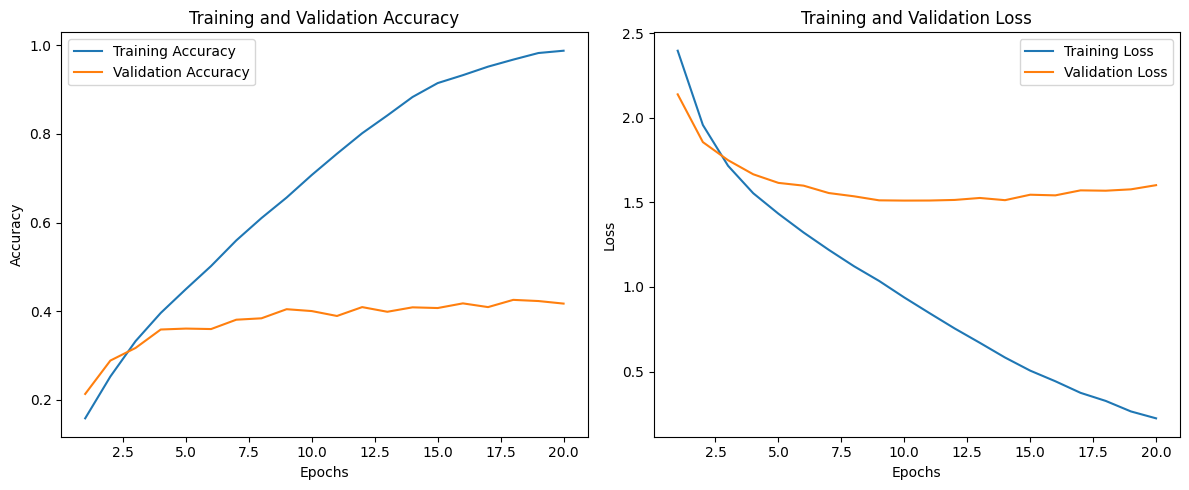


########## Gender ##########
Best Training Accuracy: 0.9978
Best Validation Accuracy: 0.8273
Best Training Loss: 0.0219
Best Validation Loss: 0.4520


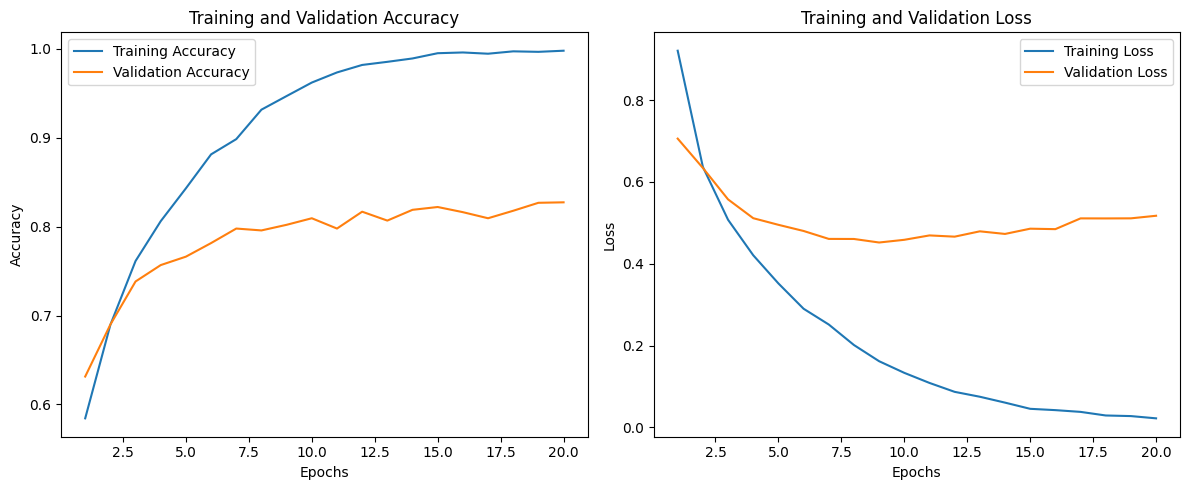


########## Race ##########
Best Training Accuracy: 0.9937
Best Validation Accuracy: 0.5613
Best Training Loss: 0.1204
Best Validation Loss: 1.1811


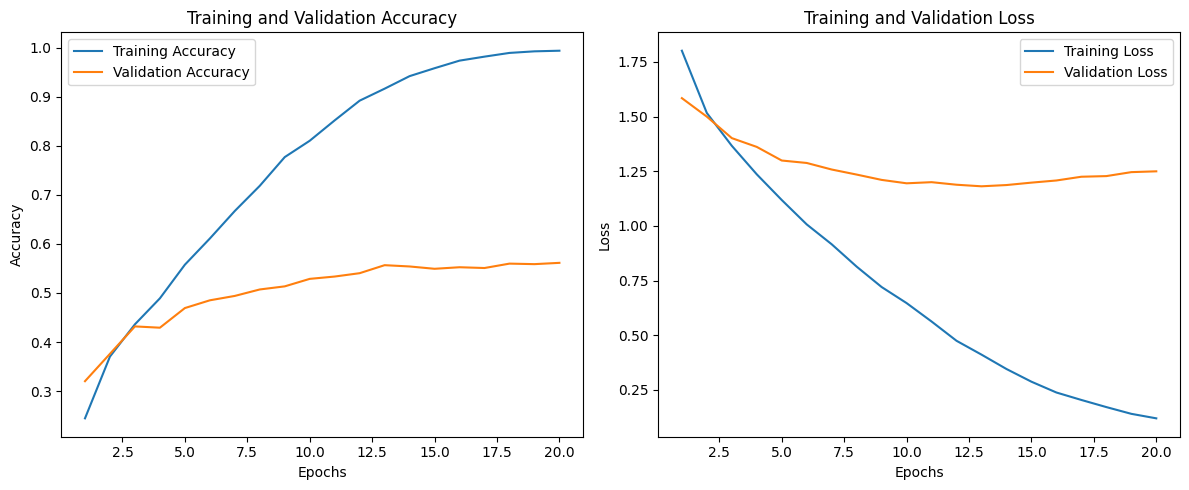

In [ ]:
print("########## Age ##########")
evaluate_and_plot(multitask_history, 'age_output_accuracy', 'val_age_output_accuracy', 'age_output_loss', 'val_age_output_loss')
print("\n########## Gender ##########")
evaluate_and_plot(multitask_history, 'gender_output_accuracy', 'val_gender_output_accuracy', 'gender_output_loss', 'val_gender_output_loss')
print("\n########## Race ##########")
evaluate_and_plot(multitask_history, 'race_output_accuracy', 'val_race_output_accuracy', 'race_output_loss', 'val_race_output_loss')

In [ ]:
def evaluate_and_print_top3(history, acc_key, val_acc_key, loss_key, val_loss_key):
    import numpy as np

    # Retrieve accuracy and loss values
    acc = history.history[acc_key]
    val_acc = history.history[val_acc_key]
    loss = history.history[loss_key]
    val_loss = history.history[val_loss_key]

    # Find the top 3 accuracies and their epochs (highest values)
    acc_top3_indices = np.argsort(acc)[::-1][:3]
    val_acc_top3_indices = np.argsort(val_acc)[::-1][:3]

    # Find the top 3 losses and their epochs (lowest values)
    loss_top3_indices = np.argsort(loss)[:3]
    val_loss_top3_indices = np.argsort(val_loss)[:3]

    # Get the top 3 accuracies and losses along with their epochs
    acc_top3 = [(i + 1, acc[i]) for i in acc_top3_indices]  # (epoch, value)
    val_acc_top3 = [(i + 1, val_acc[i]) for i in val_acc_top3_indices]
    loss_top3 = [(i + 1, loss[i]) for i in loss_top3_indices]
    val_loss_top3 = [(i + 1, val_loss[i]) for i in val_loss_top3_indices]

    # Print the top 3 values in a nicely formatted way
    print("\nTop 3 Training Accuracy:")
    for rank, (epoch, value) in enumerate(acc_top3, 1):
        print(f"{rank}. Epoch {epoch}: {value:.4f}")

    print("\nTop 3 Validation Accuracy:")
    for rank, (epoch, value) in enumerate(val_acc_top3, 1):
        print(f"{rank}. Epoch {epoch}: {value:.4f}")

    print("\nTop 3 Training Loss:")
    for rank, (epoch, value) in enumerate(loss_top3, 1):
        print(f"{rank}. Epoch {epoch}: {value:.4f}")

    print("\nTop 3 Validation Loss:")
    for rank, (epoch, value) in enumerate(val_loss_top3, 1):
        print(f"{rank}. Epoch {epoch}: {value:.4f}")

print("########## Age ##########")
evaluate_and_print_top3(
    multitask_history,
    'age_output_accuracy',
    'val_age_output_accuracy',
    'age_output_loss',
    'val_age_output_loss'
)

print("\n########## Gender ##########")
evaluate_and_print_top3(
    multitask_history,
    'gender_output_accuracy',
    'val_gender_output_accuracy',
    'gender_output_loss',
    'val_gender_output_loss'
)

print("\n########## Race ##########")
evaluate_and_print_top3(
    multitask_history,
    'race_output_accuracy',
    'val_race_output_accuracy',
    'race_output_loss',
    'val_race_output_loss'
)

########## Age ##########

Top 3 Training Accuracy:
1. Epoch 20: 0.9875
2. Epoch 19: 0.9823
3. Epoch 18: 0.9674

Top 3 Validation Accuracy:
1. Epoch 18: 0.4255
2. Epoch 19: 0.4229
3. Epoch 16: 0.4176

Top 3 Training Loss:
1. Epoch 20: 0.2233
2. Epoch 19: 0.2641
3. Epoch 18: 0.3262

Top 3 Validation Loss:
1. Epoch 10: 1.5103
2. Epoch 11: 1.5107
3. Epoch 9: 1.5118

########## Gender ##########

Top 3 Training Accuracy:
1. Epoch 20: 0.9978
2. Epoch 18: 0.9971
3. Epoch 19: 0.9965

Top 3 Validation Accuracy:
1. Epoch 20: 0.8273
2. Epoch 19: 0.8268
3. Epoch 15: 0.8220

Top 3 Training Loss:
1. Epoch 20: 0.0219
2. Epoch 19: 0.0274
3. Epoch 18: 0.0289

Top 3 Validation Loss:
1. Epoch 9: 0.4520
2. Epoch 10: 0.4586
3. Epoch 8: 0.4606

########## Race ##########

Top 3 Training Accuracy:
1. Epoch 20: 0.9937
2. Epoch 19: 0.9924
3. Epoch 18: 0.9892

Top 3 Validation Accuracy:
1. Epoch 20: 0.5613
2. Epoch 18: 0.5598
3. Epoch 19: 0.5587

Top 3 Training Loss:
1. Epoch 20: 0.1204
2. Epoch 19: 0.1410
3. 

# 7. Only FairFace

# Old stuff

# 6. Baseline MobileNet v3

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model setup

In [ ]:
# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    # input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)
12683000/12683000 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...


In [ ]:
inputs = keras.Input(shape=(images[0].shape[0], images[0].shape[1], images[0].shape[2]))
x = mobilenet_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/"
model_name = 'best_mobilenet_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_5  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_10 (Ba  (None, 960)               3840      
 tchNormalization)                                               
                                                                 
 dense_15 (Dense)            (None, 1024)              984064    
                                                           

## Model train

In [ ]:
mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/30
1172/1172 [==============================] - ETA: 0s - loss: 1.4376 - accuracy: 0.4213
Epoch 1: val_accuracy improved from -inf to 0.45880, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/best_mobilenet_model_baseline.keras
1172/1172 [==============================] - 461s 390ms/step - loss: 1.4376 - accuracy: 0.4213 - val_loss: 1.3408 - val_accuracy: 0.4588
Epoch 2/30
1172/1172 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.5349
Epoch 2: val_accuracy did not improve from 0.45880
1172/1172 [==============================] - 447s 382ms/step - loss: 1.1463 - accuracy: 0.5349 - val_loss: 1.3160 - val_accuracy: 0.4529
Epoch 3/30
1172/1172 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.6041
Epoch 3: val_accuracy improved from 0.45880 to 0.46090, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/best_mobilenet_model_baseline.keras
1172/1172 [=============================

KeyboardInterrupt: 

## Model evaluation

In [ ]:
def evaluate_and_plot(history):
  import matplotlib.pyplot as plt
  # Get the accuracy and loss data from the history object
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(accuracy) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(X_test, y_test, model):
  from sklearn.metrics import confusion_matrix
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  y_pred = model.predict(X_test)  # x_test is your test data
  y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions
  cm = confusion_matrix(y_test, y_pred) # Calculate confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=age_group_mapping.values(), yticklabels=age_group_mapping.values())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
evaluate_and_plot(mobilenet_history)
plot_confusion_matrix(X_test, y_test)

NameError: name 'mobilenet_history' is not defined

## Ekstra with lower learningrate


In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

Training set: (41208, 224, 224, 3), Training labels: (41208,)
Age validation set: (10989, 224, 224, 3), Age validation labels: (10989,)
Age test set: (2748, 224, 224, 3), Age test labels: (2748,)
Race validation labels: (10989,)
Race test labels: (2748,)
Gender validation labels: (10989,)
Gender test labels: (2748,)
12683000/12683000 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...


In [ ]:
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 960)               3840      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               492032    
                                                             

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project"
model_name = 'best_mobilenet_model_baseline_low.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [ ]:
mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
1288/1288 [==============================] - ETA: 0s - loss: 1.7705 - accuracy: 0.2986
Epoch 1: val_accuracy improved from -inf to 0.37428, saving model to /content/drive/MyDrive/Visual reg/Projectbest_mobilenet_model_baseline_low.keras
1288/1288 [==============================] - 232s 176ms/step - loss: 1.7705 - accuracy: 0.2986 - val_loss: 1.5879 - val_accuracy: 0.3743
Epoch 2/20
1288/1288 [==============================] - ETA: 0s - loss: 1.5120 - accuracy: 0.3929
Epoch 2: val_accuracy improved from 0.37428 to 0.40413, saving model to /content/drive/MyDrive/Visual reg/Projectbest_mobilenet_model_baseline_low.keras
1288/1288 [==============================] - 224s 174ms/step - loss: 1.5120 - accuracy: 0.3929 - val_loss: 1.4863 - val_accuracy: 0.4041
Epoch 3/20
1288/1288 [==============================] - ETA: 0s - loss: 1.4206 - accuracy: 0.4236
Epoch 3: val_accuracy improved from 0.40413 to 0.41787, saving model to /content/drive/MyDrive/Visual reg/Projectbest_mobilenet_m

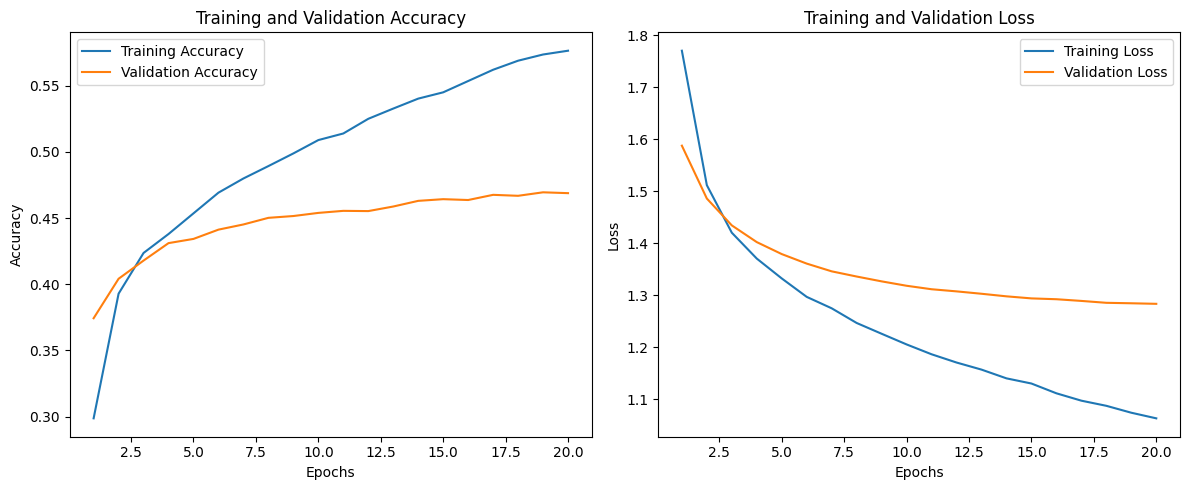

NameError: name 'y_test' is not defined

In [ ]:
evaluate_and_plot(mobilenet_history)
plot_confusion_matrix(X_test, y_test)

In [ ]:
# Create lists
images, ages, races, genders = create_lists(df[df['dataset'] == 'FairFace'])

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Define model
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project"
model_name = 'best_mobilenet_model_baseline_fairface.keras'
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

mobilenet_fairface_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

evaluate_and_plot(mobilenet_fairface_history)

Epoch 1/30
1145/1145 [==============================] - ETA: 0s - loss: 1.5177 - accuracy: 0.3806
Epoch 1: val_accuracy improved from -inf to 0.42139, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Projectbest_mobilenet_model_baseline_fairface.keras
1145/1145 [==============================] - 210s 180ms/step - loss: 1.5177 - accuracy: 0.3806 - val_loss: 1.4055 - val_accuracy: 0.4214
Epoch 2/30
1145/1145 [==============================] - ETA: 0s - loss: 1.2681 - accuracy: 0.4766
Epoch 2: val_accuracy improved from 0.42139 to 0.43316, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Projectbest_mobilenet_model_baseline_fairface.keras
1145/1145 [==============================] - 200s 174ms/step - loss: 1.2681 - accuracy: 0.4766 - val_loss: 1.3653 - val_accuracy: 0.4332
Epoch 3/30
1145/1145 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.5295
Epoch 3: val_accuracy improved from 0.43316 to 0.44350, saving model to /co

# Trying other convolutional bases

In [ ]:
# Import a couple of applications
from keras.applications import MobileNetV3Large
from keras.applications import Xception
from keras.applications import ResNet50V2

# Import conv bases
conv_base_Xception = Xception(
    include_top=False,
    weights="imagenet",
)

conv_base_ResNet = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

conv_base_MobileNet = MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
)

def build_model(input_shape, conv_base):
  name = conv_base.name
  inputs = keras.Input(shape=input_shape)
  x = conv_base(inputs)

  if name == 'xception':
    x = keras.applications.xception.preprocess_input(x)

  elif name == 'resnet50v2':
    x = keras.applications.resnet_v2.preprocess_input(x)

  elif name == 'mobilenetv3large':
    x = keras.applications.mobilenet_v3.preprocess_input(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(512, activation = 'relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(256, activation = 'relu')(x)
  outputs = layers.Dense(num_classes_age, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

# Build models
input_shape = images[0].shape
mobilenet = build_model(input_shape, conv_base_MobileNet)
xception = build_model(input_shape, conv_base_Xception)
resnet = build_model(input_shape, conv_base_ResNet)

# Compile models
mobilenet_optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
xception_optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
resnet_optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

mobilenet.compile(loss="sparse_categorical_crossentropy",
                  optimizer=mobilenet_optimizer,
                  metrics=["accuracy"])

xception.compile(loss="sparse_categorical_crossentropy",
                  optimizer=xception_optimizer,
                  metrics=["accuracy"])

resnet.compile(loss="sparse_categorical_crossentropy",
                  optimizer=resnet_optimizer,
                  metrics=["accuracy"])

# Callbacks for each conv base
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_mobilenet = ModelCheckpoint(
    '/content/drive/MyDrive/Visual reg/Project/mobilenet.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

checkpoint_xception = ModelCheckpoint(
    '/content/drive/MyDrive/Visual reg/Project/xception.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')


checkpoint_resnet = ModelCheckpoint(
    '/content/drive/MyDrive/Visual reg/Project/resnet.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
# Train mobilenet
mobilenet_history = mobilenet.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint_mobilenet]
)

evaluate_and_plot(mobilenet_history)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.4724
Epoch 1: val_accuracy improved from -inf to 0.47630, saving model to /content/drive/MyDrive/Visual reg/Project/mobilenet.keras
1172/1172 [==============================] - 761s 649ms/step - loss: 1.2722 - accuracy: 0.4724 - val_loss: 1.2636 - val_accuracy: 0.4763
Epoch 2/10
  26/1172 [..............................] - ETA: 11:26 - loss: 0.9316 - accuracy: 0.6178

KeyboardInterrupt: 

In [ ]:
# Train xception
xception_history = xception.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint_xception]
)

evaluate_and_plot(xception_history)

Epoch 1/10


KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable block1_conv1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [ ]:
# Train resnet
resnet_history = resnet.fit(
    X_train,
    y_train_age,
    epochs=310,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint_resnet]
)

evaluate_and_plot(resnet_history)

Epoch 1/310


KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable conv1_conv/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


## Multitask Learning (experiment)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base_MobileNet.name

'MobilenetV3large'

In [ ]:
# Build model
input_shape = images[0].shape
inputs = keras.Input(shape=input_shape)
x = mobilenet_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x_age = layers.Dense(64)(x)
x_ethnicity = layers.Dense(64)(x)
x_gender = layers.Dense(64)(x)
output_age = layers.Dense(num_classes_age, activation="softmax")(x_age)
output_ethnicity = layers.Dense(num_classes_ethnicity, activation="softmax")(x_ethnicity)
output_gender = layers.Dense(num_classes_gender, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=[output_age, output_ethnicity])
model.summary()

## Learning Rate Decay (experiment)

In [ ]:
# Set custom learning rate
initial_learning_rate = 1e-3  # Adjust as needed
first_decay_steps = 1000

lr_decayed_fn = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0,
    name="SGDRDecay",
)

optimizer = keras.optimizers.AdamW(learning_rate=lr_decayed_fn)


model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])